# Optimising Demand Response Strategies for Carbon Intelligent Load Shifting

# Combining Grid and Weather Data

**NOTEBOOK PURPOSE(S):**
* Combine the Grid Readings with Cleaned Weather Data

**LIMITATIONS:**
* It assumes the data is in the correct format and contains the necessary columns for processing
* The notebook does not remove nulls or handle missing data, as this is done in a separate notebook

**NOTEBOOK INPUTS:**
* weather_data_combined_20250714_1401.parquet
* grid_readings_20250714_1401_processed.parquet


**NOTEBOOK OUTPUTS:**
* Primary output:
    * weather_and_grid_data_half-hourly_20250714_1401.parquet

* Intermediate outputs:
    * grid_readings_20250714_1401_half_hourly.parquet
    * weather_20250714_1401_processed_clean_combined_half_hourly.parquet
    * weather_20250714_1401_processed_clean_combined_half_hourly_step2.parquet
    * weather_20250714_1401_processed_clean_combined_half_hourly_step2_trimmed.parquet
    * grid_readings_20250714_1401_trimmed.parquet

### Importing Libraries

In [2]:
%matplotlib inline

# ────────────────────────────────────────────────────────────────────────────
# Data Manipulation & Analysis
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import polars as pl
import numpy as np
import math


# ─────────────────────────────────────────────────────────────────────────────
# Geospatial Data Handling
# ─────────────────────────────────────────────────────────────────────────────
import xarray as xr
from xarray.coding.times import CFTimedeltaCoder
import xesmf as xe
import geopandas as gpd

# ─────────────────────────────────────────────────────────────────────────────
# Visualization
# ─────────────────────────────────────────────────────────────────────────────
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates

# ─────────────────────────────────────────────────────────────────────────────
# Notebook/Display Tools
# ─────────────────────────────────────────────────────────────────────────────
from IPython.display import display
import matplotlib.pyplot as plt


# ─────────────────────────────────────────────────────────────────────────────
# System / Miscellaneous
# ─────────────────────────────────────────────────────────────────────────────
import os
from datetime import datetime, timedelta
from typing import List, Optional, Union, Dict, Tuple, Sequence, Iterable, Literal, Mapping
from functools import reduce
from zoneinfo import ZoneInfo
from pathlib import Path
import shutil
from __future__ import annotations

import concurrent.futures
from tqdm import tqdm
import logging
import re
# import loads
import binascii
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo


## Loading Data

#### Directories

In [3]:
# DIRECTORIES AND PATHS

# This is a redundant code block, but it is included as a reminder of the directory variables.
root_directory = os.path.join('..', '..')
# Base data directory
base_data_directory = os.path.join(root_directory, "data")
hitachi_data_directory = os.path.join(base_data_directory, 'hitachi')


In [4]:
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' and subdirectories:\n" + "-" * 120)
for root, dirs, files in os.walk(hitachi_data_directory):
    for f in sorted(files):
        rel_dir = os.path.relpath(root, hitachi_data_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != "." else f
        print(f"  - {rel_file}")


------------------------------------------------------------------------------------------------------------------------
Contents of '../../data/hitachi' and subdirectories:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250714_1401.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_processed.parquet
  - grid_readings_20250714_1401_processed_half_hourly.parquet
  - meter_readings_20250701_1318.parquet
  - weather_20250714_1401.parquet
  - weather_20250714_1401_processed.parquet
  - weather_and_grid_data_half-hourly_20250714_1401.parquet
  - weather_data_combined_20250714_1401.parquet
  - meter_primary_files/.DS_Store
  - meter_primary_files/meter_readings_2021_20250714_2015.parquet
  - meter_primary_files/meter_readings_2021_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2021_Q4_20250714_2015_formatted.parquet
  - meter_primary_fi

#### File Paths

In [5]:
# cleaned weather data
weather_filename = "weather_data_combined_20250714_1401"
weather_filepath = os.path.join(hitachi_data_directory, weather_filename + ".parquet")

# Grid Data
grid_readings_filename = "grid_readings_20250714_1401_processed"
grid_readings_filepath = os.path.join(hitachi_data_directory, grid_readings_filename + ".parquet")

# Temporary files for intermediate processing
temp_files = []

#### Load and Look at Data

In [6]:
weather_pldf = pl.read_parquet(weather_filepath)
grid_readings_pldf= pl.read_parquet(grid_readings_filepath)

In [7]:
# Temporary files for intermediate results - will be cleaned up after use
temp_files = []

In [8]:
# Sample Rows of the DataFrames
print("\n" + "-" * 120)
print(f"Sample rows of Weather dataset [{weather_filename}]:\n" + "-" * 120)
display(weather_pldf.sample(8))
display(weather_pldf.schema)


------------------------------------------------------------------------------------------------------------------------
Sample rows of Weather dataset [weather_data_combined_20250714_1401]:
------------------------------------------------------------------------------------------------------------------------


timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
"datetime[μs, UTC]",cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f64,list[struct[2]]
2022-05-19 20:00:00 UTC,"""delhi""",28.5,77.34,28.5,77.300003,2.472962,186.105209,29.870026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039997,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2021-05-12 09:00:00 UTC,"""mumbai""",19.0,72.97,19.0,73.0,5.416406,268.091431,32.730743,0.0,817422.777778,903031.666667,2.942722e6,3.250914e6,0.147644,0.147644,0.0,0.0,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2023-08-09 05:00:00 UTC,"""mumbai""",19.1,72.87,19.1,72.900002,5.263638,237.365494,27.198517,0.142121,361462.604167,411062.361111,1.3013e6,1479824.5,0.998932,0.997833,0.302429,0.163666,0.030002,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2023-06-18 23:00:00 UTC,"""mumbai""",18.8,72.97,18.799999,73.0,3.924911,238.922714,27.094971,0.090455,0.0,0.0,0.0,0.0,0.9765625,0.9599,0.124268,0.170685,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2020-06-23 14:00:00 UTC,"""mumbai""",18.8,72.97,18.799999,73.0,5.638801,182.383575,26.67041,0.159118,15515.555556,17523.888889,55856.0,63086.0,0.409393,0.060608,0.340546,0.18219,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2020-12-21 01:00:00 UTC,"""delhi""",28.6,77.24,28.6,77.199997,2.789398,295.628937,8.998016,0.0,0.0,0.0,0.0,0.0,0.685242,0.685242,0.0,0.0,0.040003,[]
2021-08-18 17:00:00 UTC,"""delhi""",28.8,77.14,28.799999,77.099998,1.744223,105.194519,28.848206,0.0,0.0,0.0,0.0,0.0,0.457977,0.417969,0.06601,0.003998,0.040002,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2020-10-26 08:00:00 UTC,"""mumbai""",18.6,72.97,18.6,73.0,2.458814,310.524597,29.501007,0.021811,654335.555556,768235.833333,2.3556e6,2.765649e6,0.243561,0.184998,0.053009,0.030853,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"


Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('distance_between_locations_meters', Float64),
        ('processing_operations_log',
         List(Struct({'column': String, 'method': 

In [9]:
print("\n" + "-" * 120)
print(f"Sample rows of Grid Readings dataset [{grid_readings_filename}]:\n" + "-" * 120)
display(grid_readings_pldf.sample(8))
display(grid_readings_pldf.schema)


------------------------------------------------------------------------------------------------------------------------
Sample rows of Grid Readings dataset [grid_readings_20250714_1401_processed]:
------------------------------------------------------------------------------------------------------------------------


timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-06-06 13:15:00,79859.5,5678.5,588.092035,20366.0,4367.5,26391.5,6697.53515,136663.0,0.588092,135894.5,110271.5
2024-04-03 03:20:00,160567.0,3622.0,858.381395,7697.0,5177.0,7105.0,13173.8654,184168.0,0.858381,183740.0,177063.0
2021-11-04 07:50:00,108793.0,2840.0,742.39618,18986.0,5479.0,8415.0,8940.4916,144513.0,0.742396,144633.0,136098.0
2025-01-02 23:00:00,134877.0,1666.0,844.628797,7545.0,5828.5,6571.0,11014.4874,156487.5,0.844629,155856.5,149916.5
2021-07-12 18:15:00,111005.5,4494.5,698.484532,24741.5,3860.5,13648.5,9182.19035,157750.5,0.698485,156097.0,144102.0
2024-01-30 14:10:00,150743.5,4625.5,741.468999,5295.0,4806.0,35436.5,12413.82845,200906.5,0.741469,200219.0,165470.0
2020-04-11 13:35:00,74969.0,5702.0,661.560413,8109.0,4656.0,20863.0,6301.3078,114299.0,0.66156,115158.0,93436.0
2022-03-06 09:00:00,134860.5,2921.0,738.461186,14535.0,5594.0,21818.0,11060.2101,179728.5,0.738461,179571.0,157910.5


Schema([('timestamp', Datetime(time_unit='us', time_zone=None)),
        ('thermal_generation', Float64),
        ('gas_generation', Float64),
        ('g_co2_per_kwh', Float64),
        ('hydro_generation', Float64),
        ('nuclear_generation', Float64),
        ('renewable_generation', Float64),
        ('tons_co2', Float64),
        ('total_generation', Float64),
        ('tons_co2_per_mwh', Float64),
        ('demand_met', Float64),
        ('net_demand', Float64)])

## Processing Data

### Helper Functions

In [10]:
def degrees_to_cardinal(
        degrees: pl.Expr,
        num_directions: int = 8
) -> pl.Expr:
    """
    Convert wind direction in degrees to cardinal directions (N, NE, E, etc.)

    Parameters
    ----------
    degrees : pl.Expr
        The wind direction in degrees as a Polars expression.
    num_directions : int, optional
        The number of cardinal directions to use (4, 8 or 16). Default is 8.

    Returns
    -------
    pl.Expr
        A Polars expression that maps the degrees to cardinal directions
    """
    # Assign sector size and specify the cardinal directions based on the number of directions
    if num_directions == 8:
        sector_size = 45
        directions = [
            "N", "NE", "E", "SE", "S", "SW", "W", "NW"
        ]
    elif num_directions == 16:
        sector_size = 22.5
        directions = [
            "N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
            "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"
        ]
    elif num_directions == 4:
        sector_size = 90
        directions = [
            "N", "E", "S", "W"
        ]
    else:
        raise ValueError("num_directions must be one of 4, 8, or 16.")

    # Calculate the bin index based on the degrees and sector size
    # The degrees are adjusted by adding half the sector size to ensure proper binning
    # The result is then floored, divided by the sector size, and cast to UInt32
    sector_index = (
        ((degrees + (sector_size / 2)) % 360)
        .floordiv(sector_size)
        .cast(pl.UInt32)
    )
    # Finally, the index is replaced with the corresponding cardinal direction
    return pl.lit(directions).list.get(sector_index)


#### Weather Interpolation

##### mini utilities

In [11]:
def ensure_datetime_unit(
        lazy_dataframe: pl.LazyFrame,
        timestamp_col: str,
        precision_unit: str="us"
) -> pl.LazyFrame:
    """ Ensure that the specified timestamp column in the Polars LazyFrame is in
    microsecond precision datetime format.

    Parameters:
    ----------
    lazy_dataframe: pl.LazyFrame
        The Polars LazyFrame containing the timestamp column.
    timestamp_col: str
        The name of the timestamp column to ensure is in microsecond precision.
    precision_unit: str
        The precision unit to use for the timestamp column (default is "us").

    Returns:
    -------
    pl.LazyFrame
        The updated Polars LazyFrame with the timestamp column in the specified precision.
    """
    return lazy_dataframe.with_columns(pl.col(timestamp_col)
                                       .cast(pl.Datetime(time_unit=precision_unit)))

In [12]:
def _with_next(
        lazy_dataframe: pl.LazyFrame,
        grouping_cols: Sequence[str],
        timestamp_col: str,
        cols_to_shift: Iterable[str],
        require_exact_hour: bool = True,
) -> pl.LazyFrame:
    """
    Adds <col>__next for each col in cols_to_shift aligned by group, and filters to 60-min gaps if requested.

    Parameters:
    -----------
    lazy_dataframe: pl.LazyFrame
        The input lazy dataframe.
    group_cols: Sequence[str]
        The columns to group by.
    timestamp_col: str
        The name of the timestamp column.
    cols_to_shift: Iterable[str]
        The columns to shift.
    require_exact_hour: bool
        Whether to filter for exact 60-minute gaps.

    Returns:
    -------
    pl.LazyFrame
        The modified lazy dataframe with shifted columns.
    """
    # sort dataframe by location and timestamp
    shifted = lazy_dataframe.sort([*grouping_cols, timestamp_col]).with_columns(
                                    # retrieve the next rows value for each column and put in a new column
                                    # traversing through the timestamp within each group
                                    *[pl.col(c).shift(-1).over(grouping_cols)
                                      .alias(f"{c}__next")
                                      for c in [timestamp_col, *cols_to_shift]]
                            # extract the time difference between the current and next rows
                            ).with_columns(
                                    (pl.col(f"{timestamp_col}__next") - pl.col(timestamp_col))
                            .alias("__dt")
                            )
    # ensure that the time difference is exactly 60 minutes before returning
    return shifted.filter(pl.col("__dt") == pl.duration(minutes=60)) if require_exact_hour else shifted

In [13]:
def _midpoint_timestamp(
        timestamp_col: str,
        midpoint_time_min: int=30
) -> pl.Expr:
    """
    Returns an expression that calculates the midpoint timestamp by adding provided minutes
    to the given timestamp column. (Default is 30 minutes)

    Parameters:
    -----------
    timestamp_col: str
        The name of the timestamp column.
    midpoint_time_min: int
        The number of minutes to add to the timestamp. (Default is 30)

    Returns:
    -------
    pl.Expr
        An expression that calculates the midpoint timestamp.
    """
    return (pl.col(timestamp_col) + pl.duration(minutes=midpoint_time_min)).alias(timestamp_col)

In [14]:
# helper to merge multiple LazyFrames on the same keys (outer join across parts)
def _merge_parts_on_keys(
        parts: list[pl.LazyFrame],
        keys: list[str]
) -> Optional[pl.LazyFrame]:
    """
    Merges multiple LazyFrames on the same keys using an outer join.

    Parameters:
    -----------
    parts: list[pl.LazyFrame]
        The list of LazyFrames to merge.
    keys: list[str]
        The keys to join on.

    Returns:
    -------
    Optional[pl.LazyFrame]
        The merged LazyFrame, or None if no parts are provided.
    """
    if not parts:
        return None
    acc = parts[0]
    for lf in parts[1:]:
        acc = acc.join(lf, on=keys, how="full")
    return acc

##### Filling

In [15]:
def static_field_fill_exprs(
        static_cols: Sequence[str],
        how: str = "current",   # "current" | "next" | "nearest"
) -> list[pl.Expr]:
    """
    Builds expressions for static columns based on the specified method of filling.

    Parameters:
    -----------
    static_cols: Sequence[str]
        The static columns to build expressions for.
    how: str
        The method for filling static columns.
        - "current": take value from current hour (left/forward semantics)
        - "next": take value from next hour (right/backward semantics)
        - "nearest": pick between current vs next based on which is closer in time

    Returns:
    --------
    list[pl.Expr]
        The list of expressions for the static columns.
    """
    how = how.lower()
    if how not in {"current", "next", "nearest"}:
        raise ValueError("how must be one of {'current','next','nearest'}")

    exprs = []
    for c in static_cols:
        if how == "current":
            exprs.append(pl.col(c).alias(c))
        elif how == "next":
            exprs.append(pl.col(f"{c}__next").alias(c))
        else:  # nearest
            # midpoint is exactly in between; choose current by default (left tie-break)
            exprs.append(
                pl.when(pl.lit(True))  # placeholder for generality if timestamps irregular
                  .then(pl.col(c))
                  .otherwise(pl.col(f"{c}__next"))
                  .alias(c)
            )
    return exprs


In [16]:
def intensive_field_fill_exprs(intensive_cols: Sequence[str]) -> list[pl.Expr]:
    """
    For intensives (instant/mean quantities), use the midpoint (simple average of t and t+1h).

    Parameters:
    -----------
    intensive_cols: Sequence[str]
        The intensive columns to build expressions for.

    Returns:
    -------
    list[pl.Expr]
        The list of expressions for the intensive columns.
    """
    # Use the midpoint (simple average of t and t+1h)
    return [((pl.col(c) + pl.col(f"{c}__next")) / 2).alias(c) for c in intensive_cols]


In [17]:
def wind_field_fill_expr(
        wind_direction_col: str,
        wind_speed_col: Optional[str] = None,   # if provided, do speed-weighted circular midpoint
        weight_calc: bool = True,
) -> pl.Expr:
    """
    Circular midpoint for wind direction.
    If speed_col provided and weighted=True, weight vectors by speed.
    Uses meteorological 'from' direction in degrees [0,360).

    Parameters:
    ----------
    dir_col: str
        The name of the wind direction column.
    speed_col: Optional[str]
        The name of the wind speed column (if provided).
    weighted: bool
        Whether to use speed-weighted averaging.

    Returns:
    -------
    pl.Expr
        The expression for the filled wind direction column.
    """
    # Convert met degrees to math radians: θ_math = radians(270 - θ_met)
    to_rad = math.pi / 180.0
    dir_t = to_rad * (270 - pl.col(wind_direction_col))
    dir_n = to_rad * (270 - pl.col(f"{wind_direction_col}__next"))

    # Add weighting if provided - else set to 1
    if weight_calc and wind_speed_col is not None:
        s_t = pl.col(wind_speed_col)
        s_n = pl.col(f"{wind_speed_col}__next")
    else:
        s_t = pl.lit(1.0)
        s_n = pl.lit(1.0)

    # Compute the wind vector components with weighting
    # weighted vector sum is average direction in vector space
    u_mid = s_t * dir_t.cos() + s_n * dir_n.cos()
    v_mid = s_t * dir_t.sin() + s_n * dir_n.sin()

    # atan2(v, u) -> math radians; convert back to meteorological degrees in [0,360)
    theta_mid_math = pl.arctan2(v_mid, u_mid)
    deg = theta_mid_math * (180.0 / math.pi)
    dir_mid_met = (270 - deg) % 360
    return dir_mid_met.alias(wind_direction_col)

In [18]:
def _make_half_hour_extensive_rows(
        lazy_dataframe: pl.LazyFrame,
        grouping_cols: Sequence[str],
        timestamp_col: str,
        extensive_cols: Sequence[str],
        end_of_interval: bool = True,
) -> tuple[pl.LazyFrame, pl.LazyFrame]:
    """
    Generates two DataFrames representing the first and second half-hour intervals from each 60-minute pair,
    returning interval totals (not cumulative values). Timestamps can represent either the start
    (end_of_interval=False) or end (end_of_interval=True) of each interval.
    Only exact 60-minute gaps are processed.

    Parameters:
    ----------
    lazy_dataframe: pl.LazyFrame
        The input lazy dataframe.
    grouping_cols: Sequence[str]
        The columns to group by.
    timestamp_col: str
        The name of the timestamp column.
    extensive_cols: Sequence[str]
        The columns to create extensive features for.
    end_of_interval: bool
        Whether to use end-of-interval timestamps.
        Defaults to True - standard for electricity consumption data.

    Return:
    -------
    tuple
        A tuple of two lazyframes: (first_half_rows, second_half_rows)

    """
    # sort lazy_dataframe
    lazy_dataframe = lazy_dataframe.sort([*grouping_cols, timestamp_col])
    # create cumulative column names
    cumulative = {c: f"__cum__{c}" for c in extensive_cols}

    # calculate cumulative values for each group and store in new column
    lazy_dataframe_cumulative = lazy_dataframe.with_columns(
        *[pl.col(c).cum_sum().over(grouping_cols)
          .alias(cumulative[c]) for c in extensive_cols]
    )

    # align current/next cumulative values for exactly 60-min pairs
    w = (
        lazy_dataframe_cumulative
        .with_columns(
            pl.col(timestamp_col).shift(-1).over(grouping_cols)
            .alias(f"{timestamp_col}__next"),
            *[pl.col(cumulative[c]).shift(-1).over(grouping_cols).
              alias(f"{cumulative[c]}__next") for c in extensive_cols],
        )
        .with_columns((pl.col(f"{timestamp_col}__next") - pl.col(timestamp_col)).alias("__dt"))
        .filter(pl.col("__dt") == pl.duration(minutes=60))
    )

    if end_of_interval:
        ts_first = (pl.col(timestamp_col) + pl.duration(minutes=30)).alias(timestamp_col)
        ts_second = (pl.col(timestamp_col) + pl.duration(minutes=60)).alias(timestamp_col)
    else:
        ts_first = pl.col(timestamp_col).alias(timestamp_col)
        ts_second = (pl.col(timestamp_col) + pl.duration(minutes=30)).alias(timestamp_col)

    # First half: C_mid - C_t
    first_exprs = [(((pl.col(cumulative[c]) + pl.col(f"{cumulative[c]}__next")) / 2) - pl.col(cumulative[c])).alias(c)
                   for c in extensive_cols]
    first_rows = w.select([*grouping_cols, ts_first, *first_exprs])

    # Second half: C_next - C_mid
    second_exprs = [(pl.col(f"{cumulative[c]}__next") - ((pl.col(cumulative[c]) + pl.col(f"{cumulative[c]}__next")) / 2)).alias(c)
                    for c in extensive_cols]
    second_rows = w.select([*grouping_cols, ts_second, *second_exprs])

    return first_rows, second_rows


In [19]:
def _make_half_hour_rows_rate_shaped(
        lf: pl.LazyFrame,
        group_cols: Sequence[str],
        ts_col: str,
        cols: Sequence[str],             # columns with hourly TOTALS to shape (e.g., solar)
        end_of_interval: bool = True,
) -> tuple[pl.LazyFrame, pl.LazyFrame]:
    """
    Split each hourly total into two 30-min totals using a linear-rate model:
      - Estimate endpoint rates r0 (at t) and r1 (at t+1h) from adjacent hours,
      - Integrate over [t, t+30) and [t+30, t+60),
      - Scale halves so they sum exactly to the original hourly total.

    Returns (first_rows, second_rows).

    Parameters:
    -----------
    lf: pl.LazyFrame
        The input lazy frame containing hourly data.
    group_cols: Sequence[str]
        The columns to group by when performing the interpolation.
    ts_col: str
        The name of the timestamp column.
    cols: Sequence[str]
        The columns with hourly totals to shape (e.g., solar).
    end_of_interval: bool
        Whether to use end-of-interval timestamps for the half-hour rows.

    Returns:
    --------
    tuple[pl.LazyFrame, pl.LazyFrame]
        The first and second half-hour rows.
    """
    lf = lf.sort([*group_cols, ts_col])

    # align 'next' timestamp to ensure exact 60-min pairs
    base = (
        lf.with_columns(
            pl.col(ts_col).shift(-1).over(group_cols).alias(f"{ts_col}__next"),
            *[pl.col(c).shift(1).over(group_cols).alias(f"{c}__prev") for c in cols],
            *[pl.col(c).shift(-1).over(group_cols).alias(f"{c}__next") for c in cols],
        )
        .with_columns((pl.col(f"{ts_col}__next") - pl.col(ts_col)).alias("__dt"))
        .filter(pl.col("__dt") == pl.duration(minutes=60))
    )

    first_exprs = []
    second_exprs = []

    for c in cols:
        # Hourly totals
        e_prev = pl.col(f"{c}__prev")
        e_curr = pl.col(c)
        e_next = pl.col(f"{c}__next")

        # Average "rates" per hour (treat totals per hour as rates with H=1)
        r_prev = e_prev
        r_curr = e_curr
        r_next = e_next

        # Endpoint rate estimates at hour boundaries:
        # r0 (at t) ~ average of prev and curr; r1 (at t+1h) ~ average of curr and next
        r0 = pl.when(r_prev.is_not_null()).then((r_prev + r_curr) / 2).otherwise(r_curr)
        r1 = pl.when(r_next.is_not_null()).then((r_curr + r_next) / 2).otherwise(r_curr)

        # Provisional half-hour energies under linear rate across the hour (H=1):
        # First half: E1* = 0.5*r0 + (r1 - r0)/8
        # Second half: E2* = 0.5*r1 - (r1 - r0)/8
        e1_star = (0.5 * r0 + (r1 - r0) / 8.0)
        e2_star = (0.5 * r1 - (r1 - r0) / 8.0)

        sum_star = e1_star + e2_star
        scale = pl.when(sum_star.abs() > 0).then(e_curr / sum_star).otherwise(1.0)

        e1 = (e1_star * scale).alias(c)
        e2 = (e2_star * scale).alias(c)

        first_exprs.append(e1)
        second_exprs.append(e2)

    # Timestamps for the two halves
    if end_of_interval:
        ts_first = (pl.col(ts_col) + pl.duration(minutes=30)).alias(ts_col)
        ts_second = (pl.col(ts_col) + pl.duration(minutes=60)).alias(ts_col)
    else:
        ts_first = pl.col(ts_col).alias(ts_col)
        ts_second = (pl.col(ts_col) + pl.duration(minutes=30)).alias(ts_col)

    first_rows = base.select([*group_cols, ts_first, *first_exprs])
    second_rows = base.select([*group_cols, ts_second, *second_exprs])
    return first_rows, second_rows


##### Orchestrator:

In [20]:
def interpolate_to_half_hourly_orchestrator(
        input_filepath: str,
        output_filepath: str,
        *,
        group_cols: Sequence[str],
        timestamp_col: str = "timestamp",
        static_cols: Sequence[str] = (),
        intensive_cols: Sequence[str] = (),
        wind_dir_col: Optional[str] = None,
        wind_speed_col: Optional[str] = None,    # for speed-weighted wind direction
        use_speed_weighted_wind: bool = True,
        solar_cols_rate_shaped: Sequence[str] = (),     # solar totals to split with rate-shaped method
        extensive_cols_even_split: Sequence[str] = (),  # e.g., precip, anything you want 50/50 split
        static_fill_how: str = "current",        # "current" | "next"
        end_of_interval: bool = True,            # timestamps for extensives
        extra_null_cols: Sequence[str] = (),     # set these to null in :30 rows (e.g., logs)
        clamp_clouds_range: bool = True,
        datetime_unit: str = "us",
) -> None:
    """
    Orchestrates the interpolation of hourly data to half-hourly intervals.

    Parameters:
    ----------
    input_filepath: str
        The file path to the input parquet file.
    output_filepath: str
        The file path to the output parquet file.
    group_cols: Sequence[str]
        The columns to group by when performing the interpolation.
    timestamp_col: str
        The name of the timestamp column.
    static_cols: Sequence[str]
        The static columns to include in the interpolation.
    intensive_cols: Sequence[str]
        The intensive columns to include in the interpolation.
    wind_dir_col: Optional[str]
        The wind direction column to include in the interpolation.
    wind_speed_col: Optional[str]
        The wind speed column to include in the interpolation.
    use_speed_weighted_wind: bool
        Whether to use speed-weighted wind direction.
    solar_cols_rate_shaped: Sequence[str]
        The solar columns to split with the rate-shaped method.
    extensive_cols_even_split: Sequence[str]
        The extensive columns to split with the even-split method.
    static_fill_how: str
        The method to use for filling static columns ("current" | "next").
    end_of_interval: bool
        Whether to use end-of-interval timestamps for extensive columns.
    extra_null_cols: Sequence[str]
        The columns to set to null in :30 rows (e.g., logs).
    clamp_clouds_range: bool
        Whether to clamp cloud cover values to the range [0, 1].
    datetime_unit: str
        The unit of time for the timestamps (e.g., "us", "ms", "s").

    Returns:
    --------
    None
        writes the interpolated half-hourly data to the output parquet file.

    """
    # Load + ensure timestamp precision
    lf = pl.scan_parquet(input_filepath)
    lf = ensure_datetime_unit(lf, timestamp_col, precision_unit=datetime_unit)

    # 1) Build half-hour rows for extensives
    first_parts: list[pl.LazyFrame] = []
    second_parts: list[pl.LazyFrame] = []

    if solar_cols_rate_shaped:
        solar_first, solar_second = _make_half_hour_rows_rate_shaped(
            lf, group_cols, timestamp_col, solar_cols_rate_shaped, end_of_interval=end_of_interval
        )
        first_parts.append(solar_first)
        second_parts.append(solar_second)

    if extensive_cols_even_split:
        even_first, even_second = _make_half_hour_extensive_rows(
            lf, group_cols, timestamp_col, extensive_cols_even_split, end_of_interval=end_of_interval
        )
        first_parts.append(even_first)
        second_parts.append(even_second)

    # Combine per-half sets HORIZONTALLY by keys (avoid one-to-many duplicates)
    keys = [*group_cols, timestamp_col]
    first_rows  = _merge_parts_on_keys(first_parts,  keys)
    second_rows = _merge_parts_on_keys(second_parts, keys)

    # 2) Overwrite original :00 rows for extensives with SECOND half totals (the hour endpoint)
    hourly_updated = lf
    if second_rows is not None:
        keys = [*group_cols, timestamp_col]
        suffix = "__second"
        all_extensive_cols = tuple(solar_cols_rate_shaped) + tuple(extensive_cols_even_split)
        hourly_updated = (
            lf.join(second_rows, on=keys, how="left", suffix=suffix)
              .with_columns(
                  *[pl.coalesce([pl.col(f"{c}{suffix}"), pl.col(c)]).alias(c) for c in all_extensive_cols]
               )
              .drop(*[f"{c}{suffix}" for c in all_extensive_cols], strict=False)
        )

    # 3) Build :30 rows (intensives/static/wind) from current+next midpoints
    cols_for_next = []
    cols_for_next.extend(intensive_cols)
    if wind_dir_col:
        cols_for_next.append(wind_dir_col)
    if use_speed_weighted_wind and wind_speed_col:
        cols_for_next.append(wind_speed_col)
    cols_for_next = list(dict.fromkeys([c for c in cols_for_next if c is not None]))

    with_next_basic = _with_next(
        lazy_dataframe=hourly_updated,
        grouping_cols=group_cols,
        timestamp_col=timestamp_col,
        cols_to_shift=cols_for_next,
        require_exact_hour=True,
    )

    ts_mid = _midpoint_timestamp(timestamp_col, 30)

    # Avoid duplicates: do not emit statics that are also group keys / timestamp
    static_cols_for_30 = [c for c in static_cols if c not in group_cols and c != timestamp_col]

    exprs_30 = [
        *static_field_fill_exprs(static_cols_for_30, how=static_fill_how),
        *intensive_field_fill_exprs(intensive_cols),
    ]
    if wind_dir_col is not None:
        exprs_30.append(
            wind_field_fill_expr(
                wind_direction_col=wind_dir_col,
                wind_speed_col=wind_speed_col,
                weight_calc=(use_speed_weighted_wind and wind_speed_col is not None),
            )
        )
    exprs_30 += [pl.lit(None).alias(c) for c in extra_null_cols]

    halfhour_30 = with_next_basic.select([*group_cols, ts_mid, *exprs_30])

    # Add FIRST half-hour totals to the :30 rows
    if first_rows is not None:
        keys = [*group_cols, timestamp_col]
        halfhour_30 = halfhour_30.join(first_rows, on=keys, how="left")

    # Optional cloud clamp
    if clamp_clouds_range:
        clamp_cols = [c for c in intensive_cols if "cloud_cover" in c]
        if clamp_cols:
            halfhour_30 = halfhour_30.with_columns(*[pl.col(c).clip(0.0, 1.0) for c in clamp_cols])

    # 4) Align schemas & write
    out_cols = hourly_updated.collect_schema().names()
    existing_30 = set(halfhour_30.collect_schema().names())
    # ensure any extensive columns exist on :30 rows (join should have created them)
    for c in tuple(solar_cols_rate_shaped) + tuple(extensive_cols_even_split):
        if c not in existing_30:
            halfhour_30 = halfhour_30.with_columns(pl.lit(None).alias(c))

    final = (
        pl.concat(
            [hourly_updated.select(out_cols), halfhour_30.select(out_cols)],
            how="vertical_relaxed",
        )
        .sort([*group_cols, timestamp_col])
    )

    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)
    final.sink_parquet(output_filepath, compression="snappy", statistics=True)
    print(f"Interpolated data written to: {output_filepath}")

#### Visualisation

##### Weather Data

In [21]:
def plot_hourly_averages(
        df: pl.DataFrame,
        location_long: float,
        location_lat: float,
        start_date: str,
        end_date: str,
        longitude_col_name: str = "land_longitude",
        latitude_col_name: str = "land_latitude",
        variables: Optional[List[str]] = None,
        timezone: str = "UTC",
        figsize: tuple = (12, 6)
) -> None:
    """
    Plots hourly averages of specified variables for a given location and time period.
    Null values are replaced with 0 for plotting.

    Parameters:
    -----------
    df : pl.DataFrame
        The DataFrame containing the data to plot.
    location_long : float
        The longitude of the location to plot.
    location_lat : float
        The latitude of the location to plot.
    start_date : str
        The start date for the time period to plot (YYYY-MM-DD).
    end_date : str
        The end date for the time period to plot (YYYY-MM-DD).
    longitude_col_name : str
        The name of the longitude column in the DataFrame.
    latitude_col_name : str
        The name of the latitude column in the DataFrame.
    variables : Optional[List[str]]
        The list of variable names to plot. If None, all numeric variables will be plotted.
    timezone : str
        The timezone to use for the timestamps.
    figsize : tuple
        The size of the figure to create.

    Returns:
    --------
    None
        Displays the plots for the specified variables.

    """
    tz = ZoneInfo(timezone)

    # Localize datetimes
    start_dt = datetime.strptime(start_date, "%Y-%m-%d").replace(tzinfo=tz)
    end_dt = (datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)).replace(tzinfo=tz)
    # Filter data
    filtered = df.filter(
        ((pl.col(longitude_col_name) - location_long).abs() < 1e-4) &
        ((pl.col(latitude_col_name)  - location_lat ).abs() < 1e-4) &
        (pl.col("timestamp") >= start_dt) &
        (pl.col("timestamp") < end_dt)
    )

    if filtered.is_empty():
        raise ValueError(f"No data found for location ({location_long}, {location_lat}) between {start_date} and {end_date}")

    # Extract hour
    filtered = filtered.with_columns(
        pl.col("timestamp").dt.hour().alias("hour")
    )

    # Identify numeric variables
    if variables is None:
        numeric_cols = [col for col, dtype in filtered.schema.items()
                       if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]
        variables = [col for col in numeric_cols if col != "hour"]

    # Calculate hourly averages, filling nulls with 0
    hourly_avg = (
        filtered.group_by("hour")
        .agg(
            *[pl.col(var).cast(pl.Float64).fill_null(0).mean().alias(f"avg_{var}") for var in variables]
        )
        .sort("hour")
    )

    # Plot each variable
    for var in variables:
        plt.figure(figsize=figsize)

        hours = [int(h) for h in hourly_avg["hour"].to_list()]
        values = hourly_avg[f"avg_{var}"].to_list()

        if all(v == 0 or v is None for v in values):
            print(f"[SKIP] {var}: All values are 0 or None")
            continue

        plt.plot(hours, values, marker='o', label=f"Hourly {var}")

        ax = plt.gca()
        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 2))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
        plt.xticks(rotation=45)

        plt.title(f"Hourly {var} (Nulls=0)\n{start_date} to {end_date}")
        plt.xlabel("Hour of Day")
        plt.ylabel(var)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

##### Grid Data

In [22]:
def plot_time_series(
        df: pl.DataFrame,
        value_cols: Sequence[str],                          # columns to plot
        *,
        timestamp_col: str = "timestamp",
        start: Optional[Union[str, datetime]] = None,
        end: Optional[Union[str, datetime]] = None,
        freq_minutes: Literal[5, 30, 60] = 5,
        agg: Literal["mean", "sum", "median"] = "mean",
        labels: Optional[Mapping[str, str]] = None,         # pretty labels per col
        ylabel: Optional[str] = None,
        title: Optional[str] = None,
        figsize: Tuple[int, int] = (14, 5),
        start_y_at_zero: bool = True,
        date_fmt: str = "%b %d\n%H:%M",
        major_hour_interval: int = 3,                       # major ticks every N hours
        minor_minute_interval: int = 30,                    # minor ticks every N minutes
) -> None:
    """
    Parameters:
    -----------
    df : pl.DataFrame
        Input DataFrame containing time series data.
    value_cols : Sequence[str]
        List of columns to plot.
    timestamp_col : str, optional
        Name of the timestamp column (default: "timestamp").
    start : Optional[Union[str, datetime]], optional
        Start time for filtering (default: None).
    end : Optional[Union[str, datetime]], optional
        End time for filtering (default: None).
    freq_minutes : Literal[5, 30, 60], optional
        Frequency for resampling (default: 5).
    agg : Literal["mean", "sum", "median"], optional
        Aggregation function to use (default: "mean").
    labels : Optional[Mapping[str, str]], optional
        Mapping of column names to display labels (default: None).
    ylabel : Optional[str], optional
        Y-axis label (default: None).
    title : Optional[str], optional
        Plot title (default: None).
    figsize : Tuple[int, int], optional
        Figure size (default: (14, 5)).
    start_y_at_zero : bool, optional
        Whether to start y-axis at zero (default: True).
    date_fmt : str, optional
        Date format for x-axis (default: "%b %d\n%H:%M").
    major_hour_interval : int, optional
        Major ticks interval in hours (default: 3).
    minor_minute_interval : int, optional
        Minor ticks interval in minutes (default: 30).

    Returns:
    -------
    None
        Plots the graph with specified parameters.
    """
    # --- validate inputs
    missing = [c for c in value_cols + [timestamp_col] if c not in df.columns]
    if missing:
        raise ValueError(f"Columns not found in DataFrame: {missing}")

    # --- parse start/end
    def _to_dt(x):
        if x is None:
            return None
        return x if isinstance(x, datetime) else datetime.fromisoformat(x)

    start_dt, end_dt = _to_dt(start), _to_dt(end)

    # --- filter
    if start_dt is not None:
        df = df.filter(pl.col(timestamp_col) >= start_dt)
    if end_dt is not None:
        df = df.filter(pl.col(timestamp_col) <= end_dt)
    if df.is_empty():
        print("No data in the specified time range.")
        return

    # --- binning / aggregation
    freq_map = {5: "5m", 30: "30m", 60: "1h"}
    freq = freq_map[freq_minutes]

    df = df.with_columns(pl.col(timestamp_col).dt.truncate(freq).alias("_bin"))

    # build aggregation expressions (FIXED)
    if agg == "mean":
        agg_exprs = [pl.col(c).mean().alias(c) for c in value_cols]
    elif agg == "sum":
        agg_exprs = [pl.col(c).sum().alias(c) for c in value_cols]
    elif agg == "median":
        agg_exprs = [pl.col(c).median().alias(c) for c in value_cols]
    else:
        raise ValueError("agg must be 'mean', 'sum', or 'median'")

    agg_df = (
        df.group_by("_bin")
          .agg(agg_exprs)
          .sort("_bin")
          .rename({"_bin": "bin"})
    )

    # --- plot
    plt.figure(figsize=figsize)
    x = agg_df["bin"].to_list()

    for c in value_cols:
        label = labels.get(c, c) if labels else c
        y = agg_df[c].to_list()
        plt.plot(x, y, label=label)

    plt.title(title or f"{agg.capitalize()} over {freq_minutes}-minute bins")
    plt.xlabel("Time")
    if ylabel:
        plt.ylabel(ylabel)

    # y-axis from zero if requested
    if start_y_at_zero:
        ymax = max(float(agg_df[c].max()) for c in value_cols if agg_df[c].len() > 0)
        plt.ylim(bottom=0, top=ymax * 1.05 if ymax > 0 else 1)

    plt.grid(True, which="major", linestyle="-")
    plt.grid(True, which="minor", linestyle=":", alpha=0.4)
    plt.legend()
    plt.tight_layout()

    # axis formatting
    ax = plt.gca()
    ax.set_xlim([x[0], x[-1]])  # guard: assumes at least 1 row present
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=major_hour_interval))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=minor_minute_interval))
    plt.xticks(rotation=45)
    plt.show()

In [23]:
def plot_core_demand_variables(
        df: pl.DataFrame,
        demand_vars: list[str],
        start: str,
        end: str,
        freq_minutes: Literal[5, 30, 60] = 5,
        figsize: tuple = (14, 5),
        start_y_at_zero: bool = True
) -> None:
    """
    Plot core demand variables (net demand, total generation, demand met) over a specified time range.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing columns: timestamp, net_demand, total_generation, demand_met.
    start : str
        Start date in ISO format (e.g., "2023-01-01T00:00:00").
    end : str
        End date in ISO format (e.g., "2023-01-02T00:00:00").
    freq_minutes : int, optional
        Frequency in minutes for averaging (default: 5). Valid values are 5, 30, or 60.
    figsize : tuple, optional
        Size of the plot (default: (14, 5)).
    start_y_at_zero : bool, optional
        If True, the y-axis will start at 0 (default: True).

    Returns:
    -------
    None
        Plots the graph with specified parameters.
    """
    # Validate frequency
    freq_map = {5: "5m", 30: "30m", 60: "1h"}
    freq = freq_map[freq_minutes]

    # Convert start/end to datetime
    start_dt = datetime.fromisoformat(start)
    end_dt = datetime.fromisoformat(end)

    # Filter — no need to cast timestamp since it's already Datetime
    df = df.filter(
        (pl.col("timestamp") >= start_dt) & (pl.col("timestamp") <= end_dt)
    )

    if df.is_empty():
        print("No data in the specified time range.")
        return

    # Truncate to aggregation window
    df = df.with_columns([
        pl.col("timestamp").dt.truncate(freq).alias("bin")
    ])

    # Group and average
    agg = df.group_by("bin").agg([
        pl.col("net_demand").mean(),
        pl.col("total_generation").mean(),
        pl.col("demand_met").mean(),
    ]).sort("bin")

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(agg["bin"], agg["net_demand"], label="Net Demand (MW) (Excludes renewables)")
    plt.plot(agg["bin"], agg["total_generation"], label="Total Generation (MW)")
    plt.plot(agg["bin"], agg["demand_met"], label="Demand Met (MW)")
    plt.title(f"Grid Demand & Generation ({freq_minutes}-minute average)")
    plt.xlabel("Timestamp")
    plt.ylabel("MW")
    plt.legend()
    plt.grid(True, which="major", linestyle="-")
    plt.grid(True, which="minor", linestyle=":", alpha=0.4)
    plt.tight_layout()

    # Set y-axis limits if requested
    if start_y_at_zero:
        # Get the maximum value across all series to set upper bound
        max_val = max(agg["net_demand"].max(), agg["total_generation"].max(), agg["demand_met"].max())
        plt.ylim(bottom=0, top=max_val * 1.05)  # Add 5% padding at top

    # Rotate and format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))

    # Add minor ticks (typically every 15 minutes)
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))

    plt.xticks(rotation=45)
    plt.show()

In [24]:
def plot_variable_over_time(
        df: pl.DataFrame,
        variable: str,
        start: str,
        end: str,
        freq_minutes: Literal[5, 30, 60] = 5,
        figsize: tuple = (14, 5),
        start_y_at_zero: bool = True
) -> None:
    """
    Plot a specified variable over time, aggregated over a specified frequency.
    Uses SUM for 'tons_co2' and MEAN for all other variables.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing columns: timestamp and the specified variable.
    variable : str
        The name of the variable to plot (e.g., "temperature", "humidity").
    start : str
        Start date in ISO format (e.g., "2023-01-01T00:00:00").
    end : str
        End date in ISO format (e.g., "2023-01-02T00:00:00").
    freq_minutes : int, optional
        Frequency in minutes for aggregation (default: 5). Valid values are 5, 30, or 60.
    figsize : tuple, optional
        Size of the plot (default: (14, 5)).
    start_y_at_zero : bool, optional
        If True, the y-axis will start at 0 (default: True).

    Returns:
    -------
    None
        Plots the graph with specified parameters.
    """
    # Validate frequency
    freq_map = {5: "5m", 30: "30m", 60: "1h"}
    freq = freq_map[freq_minutes]

    # Validate variable
    if variable not in df.columns:
        raise ValueError(f"Variable '{variable}' not found in DataFrame.")

    # Convert start/end to datetime
    start_dt = datetime.fromisoformat(start)
    end_dt = datetime.fromisoformat(end)

    # Filter
    df = df.filter(
        (pl.col("timestamp") >= start_dt) & (pl.col("timestamp") <= end_dt)
    )

    if df.is_empty():
        print("No data in the specified time range.")
        return

    # Bin and aggregate - use SUM for tons_co2, MEAN for others
    df = df.with_columns([
        pl.col("timestamp").dt.truncate(freq).alias("bin")
    ])

    if variable == "tons_co2":
        agg = df.group_by("bin").agg([
            pl.col(variable).sum().alias(variable)
        ]).sort("bin")
        agg_title = f"{variable.replace('_', ' ').title()} ({freq_minutes}-minute sum)"
    else:
        agg = df.group_by("bin").agg([
            pl.col(variable).mean().alias(variable)
        ]).sort("bin")
        agg_title = f"{variable.replace('_', ' ').title()} ({freq_minutes}-minute average)"

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(agg["bin"], agg[variable], label=variable.replace("_", " ").title())
    plt.title(agg_title)
    plt.xlabel("Timestamp")
    plt.ylabel(variable)
    plt.grid(True)

    # Set y-axis limits if requested
    if start_y_at_zero:
        max_val = agg[variable].max()
        plt.ylim(bottom=0, top=max_val * 1.05 if max_val > 0 else 1)  # Add 5% padding at top

    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [25]:
def plot_daily_grid_of_variables(
        df: pl.DataFrame,
        variables: list[str],
        start: str,
        end: str,
        freq_minutes: Literal[5, 30, 60] = 5,
        figsize_per_plot: tuple = (6, 2.5),
        unify_y_axis: bool = True
) -> None:
    """
    Plot a grid of daily subplots for specified variables over a given time range.
    Uses SUM for 'tons_co2' and MEAN for all other variables.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing columns: timestamp and the specified variables.
    variables : list[str]
        List of variable names to plot (e.g., ["tons_co2", "thermal_generation"]).
    start : str
        Start date in ISO format (e.g., "2023-01-01T00:00:00").
    end : str
        End date in ISO format (e.g., "2023-01-02T00:00:00").
    freq_minutes : int, optional
        Frequency in minutes for binning (default: 5). Valid values are 5, 30, or 60.
    figsize_per_plot : tuple, optional
        Size of each subplot (default: (6, 2.5)).
    unify_y_axis : bool, optional
        If True, all subplots will share the same y-axis limits (default: True).
    """
    # Validate frequency
    freq_map = {5: "5m", 30: "30m", 60: "1h"}
    freq = freq_map[freq_minutes]

    # Parse and adjust time
    start_dt = datetime.fromisoformat(start)
    end_dt = datetime.fromisoformat(end) + timedelta(days=1)

    # Filter once for the entire date range
    df_filtered = df.filter((pl.col("timestamp") >= start_dt) & (pl.col("timestamp") < end_dt))
    if df_filtered.is_empty():
        print("No data in the specified time range.")
        return

    # Add date and time bin columns
    df_processed = df_filtered.with_columns([
        pl.col("timestamp").dt.truncate(freq).alias("bin"),
        pl.col("timestamp").dt.date().alias("date")
    ])

    # Get unique days in the filtered data
    unique_days = sorted(df_processed["date"].unique().to_list())
    n_rows = len(unique_days)
    n_cols = len(variables)

    # Calculate global y-max if needed - using appropriate aggregation for each variable
    global_ymax = 0.0 if unify_y_axis else None
    if unify_y_axis:
        for var in variables:
            if var == "tons_co2":
                max_val = df_processed.select(pl.col(var).sum()).item()
            else:
                max_val = df_processed.select(pl.col(var).max()).item()
            if max_val is not None:
                global_ymax = max(global_ymax, max_val)

    # Create figure and axes with proper layout
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows),
        squeeze=False  # This ensures axes is always 2D
    )

    for i, date in enumerate(unique_days):
        # Filter for the current day once
        daily_df = df_processed.filter(pl.col("date") == date)

        for j, var in enumerate(variables):
            ax = axes[i][j]

            # Group and aggregate - use SUM for tons_co2, MEAN for others
            if var == "tons_co2":
                var_df = daily_df.group_by("bin").agg(pl.col(var).sum()).sort("bin")
                title_suffix = " (sum)"
            else:
                var_df = daily_df.group_by("bin").agg(pl.col(var).mean()).sort("bin")
                title_suffix = " (avg)"

            if var_df.height == 0:
                ax.set_title(f"{var} — {date} (no data)")
                ax.set_ylim(bottom=0)
                continue

            x = var_df["bin"].to_list()
            y = var_df[var].to_list()

            # Explicitly plot with a solid line and markers
            ax.plot(x, y, '-o', markersize=3, linewidth=1)
            ax.set_title(f"{var.replace('_', ' ').title()} — {date}{title_suffix}")

            # Set y-limits
            if unify_y_axis:
                ax.set_ylim(0, global_ymax * 1.05 if global_ymax > 0 else 1)
            else:
                local_max = max(y) if y else 0
                ax.set_ylim(0, local_max * 1.05 if local_max > 0 else 1)

            # Set x-limits and format
            day_start = datetime.combine(date, datetime.min.time())
            day_end = day_start + timedelta(days=1)
            ax.set_xlim([day_start, day_end])
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
            ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
            ax.grid(True, which='major')
            ax.grid(True, which='minor', linestyle=":", alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [26]:
def prepare_generation_data(
        df: pl.DataFrame,
        sources: Optional[list[str]] = None,
        freq: Literal["quarterly", "annual"] = "quarterly"
) -> pl.DataFrame:
    """
    Prepare generation data for plotting by specified frequency.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame with timestamp and generation columns
    sources : list[str], optional
        Which generation sources to include (default: all available)
    freq : str, optional
        Aggregation frequency ("quarterly" or "annual") (default: "quarterly")

    Returns:
    -------
    pl.DataFrame
        Processed data ready for plotting
    """
    # Available sources with labels
    available_sources = {
        'thermal_generation': 'Thermal',
        'gas_generation': 'Gas',
        'nuclear_generation': 'Nuclear',
        'hydro_generation': 'Hydro',
        'renewable_generation': 'Renewable',
    }

    # Validate and set sources
    if sources is None:
        sources = list(available_sources.keys())
    else:
        invalid = [s for s in sources if s not in available_sources]
        if invalid:
            raise ValueError(f"Invalid sources: {invalid}. Available: {list(available_sources.keys())}")

    # Extract time components
    df = df.with_columns(
        pl.col("timestamp").dt.year().alias("year")
    )

    if freq == "quarterly":
        df = df.with_columns(
            pl.col("timestamp").dt.quarter().alias("quarter")
        )
        group_cols = ["year", "quarter"]
    else:
        group_cols = ["year"]

    # Aggregate data
    agg_exprs = [pl.col(source).mean().alias(source) for source in sources]
    agg_exprs.append(pl.col("total_generation").mean())

    aggregated = df.group_by(group_cols).agg(agg_exprs).sort(group_cols)

    # Create period label
    if freq == "quarterly":
        aggregated = aggregated.with_columns(
            pl.format("Q{} {}", "quarter", "year").alias("period")
        )
    else:
        aggregated = aggregated.with_columns(
            pl.col("year").cast(str).alias("period")
        )

    return aggregated


### Aggregating Grid Readings Data

In [27]:
print("\n" + "-" * 120)
print("Columns in [grid_readings_pldf]:\n"+  "-" * 120)
display(grid_readings_pldf.columns)

print("\n" + "-" * 120)
print("Descriptive statistics of [grid_readings_pldf]:\n" + "-" * 120)
display((grid_readings_pldf.describe()))


------------------------------------------------------------------------------------------------------------------------
Columns in [grid_readings_pldf]:
------------------------------------------------------------------------------------------------------------------------


['timestamp',
 'thermal_generation',
 'gas_generation',
 'g_co2_per_kwh',
 'hydro_generation',
 'nuclear_generation',
 'renewable_generation',
 'tons_co2',
 'total_generation',
 'tons_co2_per_mwh',
 'demand_met',
 'net_demand']


------------------------------------------------------------------------------------------------------------------------
Descriptive statistics of [grid_readings_pldf]:
------------------------------------------------------------------------------------------------------------------------


statistic,timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""570528""",570528.0,570528.0,570528.0,570528.0,570528.0,570528.0,570528.0,570528.0,570528.0,570528.0,570528.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-17 11:57:30""",127346.99741,3880.785326,734.108622,17808.916682,5098.942404,18015.883059,10486.105639,172146.160136,0.734109,170937.702059,154135.641823
"""std""",null,20929.047729,1620.848766,76.623441,8629.665762,789.209396,14634.005601,1690.972818,26399.888903,0.076623,26102.733504,22116.855341
"""min""","""2020-01-01 00:00:00""",65919.0,0.0,483.357945,509.0,2275.0,0.0,5549.6103,88658.0,0.483358,87972.0,86367.0
"""25%""","""2021-05-10 06:00:00""",111910.0,2564.0,681.210644,10113.0,4444.0,6721.0,9232.4828,153537.0,0.681211,152488.0,138505.0
"""50%""","""2022-09-17 12:00:00""",128637.5,3459.0,734.650696,16951.0,5127.0,12809.0,10567.71385,172636.0,0.734651,171267.0,154066.0
"""75%""","""2024-01-25 17:55:00""",143299.0,4920.5,797.193195,24837.0,5580.156566,25199.0,11761.5755,192617.5,0.797193,191037.0,169526.0
"""max""","""2025-06-03 23:55:00""",179602.0,13125.0,905.09159,45871.5,7085.0,82136.0,14812.6736,258643.0,0.905092,256491.0,225340.0


In [28]:
# Stats:
print(f"Time Start: {grid_readings_pldf['timestamp'].min()}")
print(f"Time End: {grid_readings_pldf['timestamp'].max()}")

Time Start: 2020-01-01 00:00:00
Time End: 2025-06-03 23:55:00


There are a few important things we must note about our data before we perform these aggregations:
1. Regarding the units of the generation fields.
    * Each of these columns are in MW.
        * This is according to the website where this data was originally sourced (https://carbontracker.in/)
    * It is important that this is a measurement of power, which is the rate at which energy is used/transmitted (MW = Mega Watts, Watt = Joules / Second)
    * Therefore when transforming data to higher level time frequencies (i.e. from 5 minute to 30 minute intervals), we need to AVERAGE and not AGGREGATE these values.

2. Regarding the interpretation of time:
    * Each reading is aggregated back, meaning that data from 09:55-10:00 would be recorded as 09:55.
    * This is different from the standard convention for meter readings where the time marks the END of the read period
        * That is data for 09:55 would be that from 09:50 to 09:55
        * https://law.resource.org/pub/in/bis/S05/is.15959.2011.pdf (page 17 - table 23 - note 3)
    * This means that we simply have to adjust the time and then ensure any aggregations that we do use the same methodology. That being that the time for which the data is stored represents the end of that time block/interval in which the data was collected.


In [29]:
# Half-hourly aggregation
grid_readings_pldf = grid_readings_pldf.sort("timestamp", descending=False, nulls_last=True)
# Adjusted timestamp
# - shift each of the timestamps 5 minutes forward to align with the convention of aggregating meter readings (data recorded at end time of interval)
grid_readings_pldf = (
    grid_readings_pldf.with_columns(
        (pl.col("timestamp") + pl.duration(minutes=5)).alias("end_timestamp")
    )
)
# View the results to verify the adjustment
display(grid_readings_pldf.head(8))


timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand,end_timestamp
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs]
2020-01-01 00:00:00,100003.0,4268.5,805.925374,7297.0,4267.0,7456.0,8280.31235,123291.5,0.805925,123405.0,115835.5,2020-01-01 00:05:00
2020-01-01 00:05:00,99544.5,4242.5,807.067261,7094.5,4269.5,7398.0,8242.10715,122549.0,0.807067,122547.0,115151.0,2020-01-01 00:10:00
2020-01-01 00:10:00,99442.0,4238.0,808.141541,7043.0,4267.0,7270.0,8233.6154,122260.0,0.808142,122076.0,114990.0,2020-01-01 00:15:00
2020-01-01 00:15:00,99327.5,4246.0,808.124328,7044.0,4268.0,7243.5,8224.618,122129.0,0.808124,122019.0,114885.5,2020-01-01 00:20:00
2020-01-01 00:20:00,99170.0,4220.0,807.307354,7204.0,4272.0,7182.0,8210.854,122048.0,0.807307,121965.0,114866.0,2020-01-01 00:25:00
2020-01-01 00:25:00,98856.0,4252.0,806.835579,7202.0,4269.0,7179.0,8186.5572,121758.0,0.806836,121824.0,114579.0,2020-01-01 00:30:00
2020-01-01 00:30:00,98750.0,4270.0,807.214002,7095.0,4269.0,7199.0,8178.625,121583.0,0.807214,121726.0,114384.0,2020-01-01 00:35:00
2020-01-01 00:35:00,98534.0,4259.0,808.067462,6895.0,4269.0,7231.0,8160.6733,121188.0,0.808067,121162.0,113957.0,2020-01-01 00:40:00


In [30]:
# Now we will aggregate the grid readings to half-hourly intervals.

# Ideally we'd use dt.ceil to round the timestamp UP to the next halfhour.
# Unfortunately this is not yet implemented in polars, so we have to do this manually.
# We accomplish this by adding 29 minutes and 59 seconds to each reading, and then using
# truncate function (which IS supported) to round readings down.
# This is important because meter readings are aggregated UP to the next half-hour, so we need
# to ensure that we are following the same convention.

grid_readings_half_hourly_pldf = (
    grid_readings_pldf.with_columns(
        (pl.col("end_timestamp") + pl.duration(minutes=29, seconds=59))
            .dt.truncate("30m")
            .alias("timestamp")
        )
    .group_by("timestamp")
    .agg(
        [
            # Average generation values for each type of generation
            pl.col("thermal_generation").mean().alias("thermal_generation"),
            pl.col("gas_generation").mean().alias("gas_generation"),
            pl.col("hydro_generation").mean().alias("hydro_generation"),
            pl.col("nuclear_generation").mean().alias("nuclear_generation"),
            pl.col("renewable_generation").mean().alias("renewable_generation"),
            pl.col("total_generation").mean().alias("total_generation"),

            # Average demand values
            pl.col("demand_met").mean().alias("demand_met"),
            # Note that this field (though labeled demand) actually refers to non-renewable generation
            # https://carbontracker.in/
            pl.col("net_demand").mean().alias("non_renewable_generation"),

            # Aggregate the calculated emissions
            pl.col("tons_co2").sum().alias("tons_co2"),

            # Average the relative difference and emission factors.
            pl.col("g_co2_per_kwh").mean().alias("g_co2_per_kwh"),
            pl.col("tons_co2_per_mwh").mean().alias(
                "tons_co2_per_mwh")
        ]
    )
    .sort("timestamp")
)

# Viewing the results of the aggregation
display(grid_readings_half_hourly_pldf.sort("timestamp").head(5))

timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-01-01 00:30:00,99390.5,4244.5,7147.416667,4268.75,7288.083333,122339.25,122306.0,115051.166667,49378.0641,807.233573,0.807234
2020-01-01 01:00:00,98136.75,4238.583333,6804.833333,4271.583333,7149.75,120601.5,120565.333333,113451.75,48765.90585,808.716464,0.808716
2020-01-01 01:30:00,96729.833333,4233.5,6432.833333,4264.333333,6897.0,118557.5,118515.083333,111660.5,48079.3123,811.070353,0.81107
2020-01-01 02:00:00,95512.0,4253.666667,6589.166667,4261.5,6460.75,117077.083333,116887.166667,110616.333333,47490.5214,811.271443,0.811271
2020-01-01 02:30:00,94471.5,4254.25,6699.0,4258.666667,6116.166667,115799.583333,115533.916667,109683.416667,46983.72105,811.465373,0.811465


In [31]:
# Manual Check
# Take the average of the first 6 readings in the original data to see if it matches the half_hourly aggregation
test = grid_readings_pldf.select(
    pl.col("thermal_generation").head(6).mean().alias("average_thermal_generation"),
    pl.col("gas_generation").head(6).mean().alias("average_gas_generation"),
    pl.col("hydro_generation").head(6).mean().alias("average_hydro_generation"),
    pl.col("nuclear_generation").head(6).mean().alias("average_nuclear_generation"),
    pl.col("renewable_generation").head(6).mean().alias("average_renewable_generation"),
    pl.col("total_generation").head(6).mean().alias("average_total_generation"),
    pl.col("tons_co2").head(6).sum().alias("sum_tons_co2"),
)
print("\n" + "-" * 120)
print("Average of the first 6 readings of thermal_generation in the original data:")
display(test)


------------------------------------------------------------------------------------------------------------------------
Average of the first 6 readings of thermal_generation in the original data:


average_thermal_generation,average_gas_generation,average_hydro_generation,average_nuclear_generation,average_renewable_generation,average_total_generation,sum_tons_co2
f64,f64,f64,f64,f64,f64,f64
99390.5,4244.5,7147.416667,4268.75,7288.083333,122339.25,49378.0641


In [32]:
grid_readings_half_hourly_filepath = grid_readings_filepath.replace(".parquet", "_half_hourly.parquet")

try:

    grid_readings_half_hourly_pldf.write_parquet(
    grid_readings_half_hourly_filepath,
        compression="snappy",
        statistics=True,
    )
    print(f"Successfully wrote half-hourly grid readings to {grid_readings_half_hourly_filepath}")
    # temp_files.append(grid_readings_half_hourly_filepath)
except Exception as e:
    print(f"Error writing half-hourly grid readings: {e}")


Successfully wrote half-hourly grid readings to ../../data/hitachi/grid_readings_20250714_1401_processed_half_hourly.parquet


In [33]:
grid_readings_half_hourly_pldf_reload = pl.read_parquet(grid_readings_half_hourly_filepath)

display(grid_readings_half_hourly_pldf_reload.head(5))
display(grid_readings_half_hourly_pldf_reload.describe())


timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-01-01 00:30:00,99390.5,4244.5,7147.416667,4268.75,7288.083333,122339.25,122306.0,115051.166667,49378.0641,807.233573,0.807234
2020-01-01 01:00:00,98136.75,4238.583333,6804.833333,4271.583333,7149.75,120601.5,120565.333333,113451.75,48765.90585,808.716464,0.808716
2020-01-01 01:30:00,96729.833333,4233.5,6432.833333,4264.333333,6897.0,118557.5,118515.083333,111660.5,48079.3123,811.070353,0.81107
2020-01-01 02:00:00,95512.0,4253.666667,6589.166667,4261.5,6460.75,117077.083333,116887.166667,110616.333333,47490.5214,811.271443,0.811271
2020-01-01 02:30:00,94471.5,4254.25,6699.0,4258.666667,6116.166667,115799.583333,115533.916667,109683.416667,46983.72105,811.465373,0.811465


statistic,timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""95088""",95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-17 12:15:00""",127346.99741,3880.785326,17808.916682,5098.942404,18015.883059,172146.160136,170937.702059,154135.641823,62916.633837,734.108622,0.734109
"""std""",null,20916.196838,1619.355378,8617.821113,788.865947,14612.596141,26379.403551,26081.970354,22092.847367,10139.404973,76.549608,0.07655
"""min""","""2020-01-01 00:30:00""",66097.833333,109.483135,2516.0,2281.083333,0.0,95950.333333,96848.5,86763.333333,33384.3019,483.357945,0.483358
"""25%""","""2021-05-10 06:30:00""",111923.333333,2565.083333,10134.916667,4444.0,6740.833333,153551.166667,152501.5,138526.0,55405.58295,681.281762,0.681282
"""50%""","""2022-09-17 12:30:00""",128648.583333,3457.833333,16946.166667,5126.666667,12830.5,172655.166667,171276.583333,154052.0,63403.42905,734.684328,0.734684
"""75%""","""2024-01-25 18:00:00""",143295.5,4922.083333,24823.166667,5580.25,25190.333333,192577.333333,191039.902778,169530.333333,70569.09085,797.078569,0.797079
"""max""","""2025-06-04 00:00:00""",177508.083333,12915.75,43162.083333,7070.0,81927.666667,251763.666667,249591.916667,217778.833333,88742.75695,905.09159,0.905092


### Downsampling Weather Data

In [34]:
display(weather_pldf.sample(8))

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
"datetime[μs, UTC]",cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f64,list[struct[2]]
2024-03-16 16:00:00 UTC,"""delhi""",28.7,77.24,28.700001,77.199997,1.800251,306.625183,18.896942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040003,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2024-12-16 03:00:00 UTC,"""mumbai""",19.1,72.87,19.1,72.900002,2.589749,70.524414,19.712006,0.0,127558.170573,141068.748915,459209.414062,507847.496094,0.0,0.0,0.0,0.0,0.030002,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2025-02-17 20:00:00 UTC,"""delhi""",28.8,77.24,28.799999,77.199997,2.278492,333.316589,15.764862,0.0,0.0,0.0,0.0,0.0,0.89798,0.600433,0.853973,0.0,0.040003,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2022-02-15 05:00:00 UTC,"""mumbai""",18.6,72.97,18.6,73.0,3.48445,8.928162,25.437469,0.0,507358.333333,586925.625,1.82649e6,2.1129e6,0.0,0.0,0.0,0.0,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2021-12-04 11:00:00 UTC,"""mumbai""",18.7,72.97,18.700001,73.0,2.882175,242.30365,26.565765,0.028412,249268.333333,286038.888889,897366.0,1.0297e6,0.199921,0.0,0.155518,0.122162,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2023-10-15 23:00:00 UTC,"""delhi""",28.8,76.94,28.799999,76.900002,2.140282,124.08078,21.906982,0.0,0.0,0.0,0.0,0.0,0.241791,0.191711,0.052063,0.0,0.039998,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2023-12-07 19:00:00 UTC,"""mumbai""",19.2,72.87,19.200001,72.900002,2.668421,19.24881,24.624023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030002,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2021-12-02 16:00:00 UTC,"""mumbai""",19.3,72.87,19.299999,72.900002,1.764864,29.166443,22.457123,0.042835,0.0,0.555556,0.0,2.0,0.999634,0.656616,0.35907,0.998901,0.030002,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"


In [35]:
weather_pldf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('distance_between_locations_meters', Float64),
        ('processing_operations_log',
         List(Struct({'column': String, 'method': 

In [36]:
half_hour_input_filepath = weather_filepath
half_hour_output_filepath = weather_filepath.replace(".parquet", "_half_hourly.parquet")

In [37]:
grouping_cols = ["land_latitude", "land_longitude"]
static_fill_forward_cols = ["city", "land_latitude", "land_longitude", "world_latitude", "world_longitude", "distance_between_locations_meters"]

instant_meas_cols = [
    "temperature_celsius",
    "wind_speed_mps",
    "total_cloud_cover", "high_cloud_cover", "medium_cloud_cover", "low_cloud_cover",
]

precipitation_col = [
    "precipitation_mm",
]

solar_cols = [
    "surface_net_solar_radiation_kWh_per_m2",
    "surface_solar_radiation_downwards_kWh_per_m2",
    "surface_net_solar_radiation_joules_per_m2",
    "surface_solar_radiation_downwards_joules_per_m2",
]

In [38]:
try:
    interpolate_to_half_hourly_orchestrator(
        input_filepath= half_hour_input_filepath,
        output_filepath= half_hour_output_filepath,
        group_cols= grouping_cols,
        static_cols= static_fill_forward_cols,
        intensive_cols= instant_meas_cols,
        solar_cols_rate_shaped= solar_cols,
        extensive_cols_even_split= precipitation_col,
        wind_dir_col="wind_direction_meteorological",
        wind_speed_col="wind_speed_mps",
        use_speed_weighted_wind=True,
        static_fill_how="current",
        end_of_interval=True,
        extra_null_cols=["processing_operations_log"],
        clamp_clouds_range=True,
        datetime_unit="us",
    )
    temp_files.append(half_hour_output_filepath)
except Exception as e:
    print(f"Error during half-hourly interpolation: {e}")

Interpolated data written to: ../../data/hitachi/weather_data_combined_20250714_1401_half_hourly.parquet


In [39]:
output_df = pl.read_parquet(half_hour_output_filepath)

In [40]:
output_df.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone=None)),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('distance_between_locations_meters', Float64),
        ('processing_operations_log',
         List(Struct({'column': String, 'method': S

In [41]:
output_df = output_df.drop(["land_latitude_right", "land_longitude_right", "timestamp_right"])

In [42]:
output_df.head(10)

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
datetime[μs],cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f64,list[struct[2]]
2020-01-01 00:00:00,"""mumbai""",18.5,72.97,18.5,73.0,2.137666,21.740845,17.331909,0.001255,4.4554e6,5.0640e6,1.6039574e7,1.8230394e7,0.0,0.0,0.0,0.0,0.03,[]
2020-01-01 00:30:00,"""mumbai""",18.5,72.97,18.5,73.0,2.012507,24.713623,17.199097,0.0,2.5990e6,2.9540e6,9.3564e6,1.0634e7,0.0,0.0,0.0,0.0,0.03,null
2020-01-01 01:00:00,"""mumbai""",18.5,72.97,18.5,73.0,1.887349,28.081085,17.066284,0.0,1.8564e6,2.1100e6,6.6832e6,7595997.5,0.0,0.0,0.0,0.0,0.03,[]
2020-01-01 01:30:00,"""mumbai""",18.5,72.97,18.5,73.0,1.80441,30.52887,17.07872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,null
2020-01-01 02:00:00,"""mumbai""",18.5,72.97,18.5,73.0,1.72147,33.212708,17.091156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2020-01-01 02:30:00,"""mumbai""",18.5,72.97,18.5,73.0,1.529479,28.472717,18.091583,0.0,861.750742,979.542124,3102.302671,3526.351647,0.0,0.0,0.0,0.0,0.03,null
2020-01-01 03:00:00,"""mumbai""",18.5,72.97,18.5,73.0,1.337487,22.367371,19.09201,0.0,2396.030834,2723.504751,8625.711001,9804.617103,0.0,0.0,0.0,0.0,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2020-01-01 03:30:00,"""mumbai""",18.5,72.97,18.5,73.0,1.242794,20.558228,20.927017,0.0,37867.899486,43035.725114,136324.43815,154928.610411,0.0,0.0,0.0,0.0,0.03,null
2020-01-01 04:00:00,"""mumbai""",18.5,72.97,18.5,73.0,1.1481,18.450562,22.762024,0.0,67793.502966,77044.726275,244056.610678,277361.014589,0.0,0.0,0.0,0.0,0.03,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"


In [43]:
output_df.describe()

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""4272525""","""4272525""",4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,2.136285e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.13624e6
"""mean""","""2022-09-15 23:59:59.999999""",null,25.393333,75.701111,25.393333,75.684448,2.628678,209.708649,25.250099,0.073619,83892.747074,100685.961949,326055.977172,390541.762503,0.358227,0.261578,0.15217,0.108001,0.036667,null
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,1.381585,108.889191,6.983283,0.331403,121288.164321,145163.046404,444710.546454,530957.466648,0.389875,0.379374,0.244133,0.222041,0.004713,null
"""min""","""2020-01-01 00:00:00""",null,18.5,72.77,18.5,72.800003,0.002416,0.0,0.487457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,null
"""25%""","""2021-05-09 12:00:00""",null,19.2,72.97,19.200001,73.0,1.68921,108.692078,21.503815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030002,null
"""50%""","""2022-09-16 00:00:00""",null,28.5,76.94,28.5,76.900002,2.407432,244.406693,26.366913,0.0,18.452495,22.273856,12591.478629,15056.932644,0.177643,0.000443,0.020996,0.0,0.039997,null
"""75%""","""2024-01-23 12:00:00""",null,28.7,77.14,28.700001,77.099998,3.305301,305.047485,29.59906,0.00268,161857.496908,194979.715337,648821.436581,779291.27267,0.763901,0.532104,0.21283,0.093506,0.04,null
"""max""","""2025-06-01 00:00:00""",null,28.8,77.34,28.799999,77.300003,19.006941,359.999786,46.374786,16.246036,4.6355e6,5.0640e6,1.6688e7,1.8230394e7,1.0,1.0,1.0,1.0,0.040003,null


In [44]:
output_df.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone=None)),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('distance_between_locations_meters', Float64),
        ('processing_operations_log',
         List(Struct({'column': String, 'method': S

In [45]:
output_df = output_df.with_columns(
    pl.col("distance_between_locations_meters").cast(pl.Float32)
)

In [46]:
output_df.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone=None)),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('distance_between_locations_meters', Float32),
        ('processing_operations_log',
         List(Struct({'column': String, 'method': S

In [47]:
half_hour_output_filepath_step2 = half_hour_output_filepath.replace(".parquet", "_step2.parquet")

try:
    output_df.write_parquet(
        half_hour_output_filepath_step2,
        compression="snappy",
        statistics=True,
    )
    print(f"Cleaned Half-hourly weather data written to: {half_hour_output_filepath_step2}")
    temp_files.append(half_hour_output_filepath_step2)
except Exception as e:
    print(f"Error writing cleaned half-hourly weather data: {e}")

Cleaned Half-hourly weather data written to: ../../data/hitachi/weather_data_combined_20250714_1401_half_hourly_step2.parquet


### Joining And Processing Data

In [48]:
# processed dataframes
half_hour_grid_data_pldf = pl.read_parquet(grid_readings_half_hourly_filepath)
half_hour_weather_data_pldf = pl.read_parquet(half_hour_output_filepath_step2)

In [49]:
half_hour_grid_data_pldf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone=None)),
        ('thermal_generation', Float64),
        ('gas_generation', Float64),
        ('hydro_generation', Float64),
        ('nuclear_generation', Float64),
        ('renewable_generation', Float64),
        ('total_generation', Float64),
        ('demand_met', Float64),
        ('non_renewable_generation', Float64),
        ('tons_co2', Float64),
        ('g_co2_per_kwh', Float64),
        ('tons_co2_per_mwh', Float64)])

#### Plotting Data as Visual Check

##### Grid Data

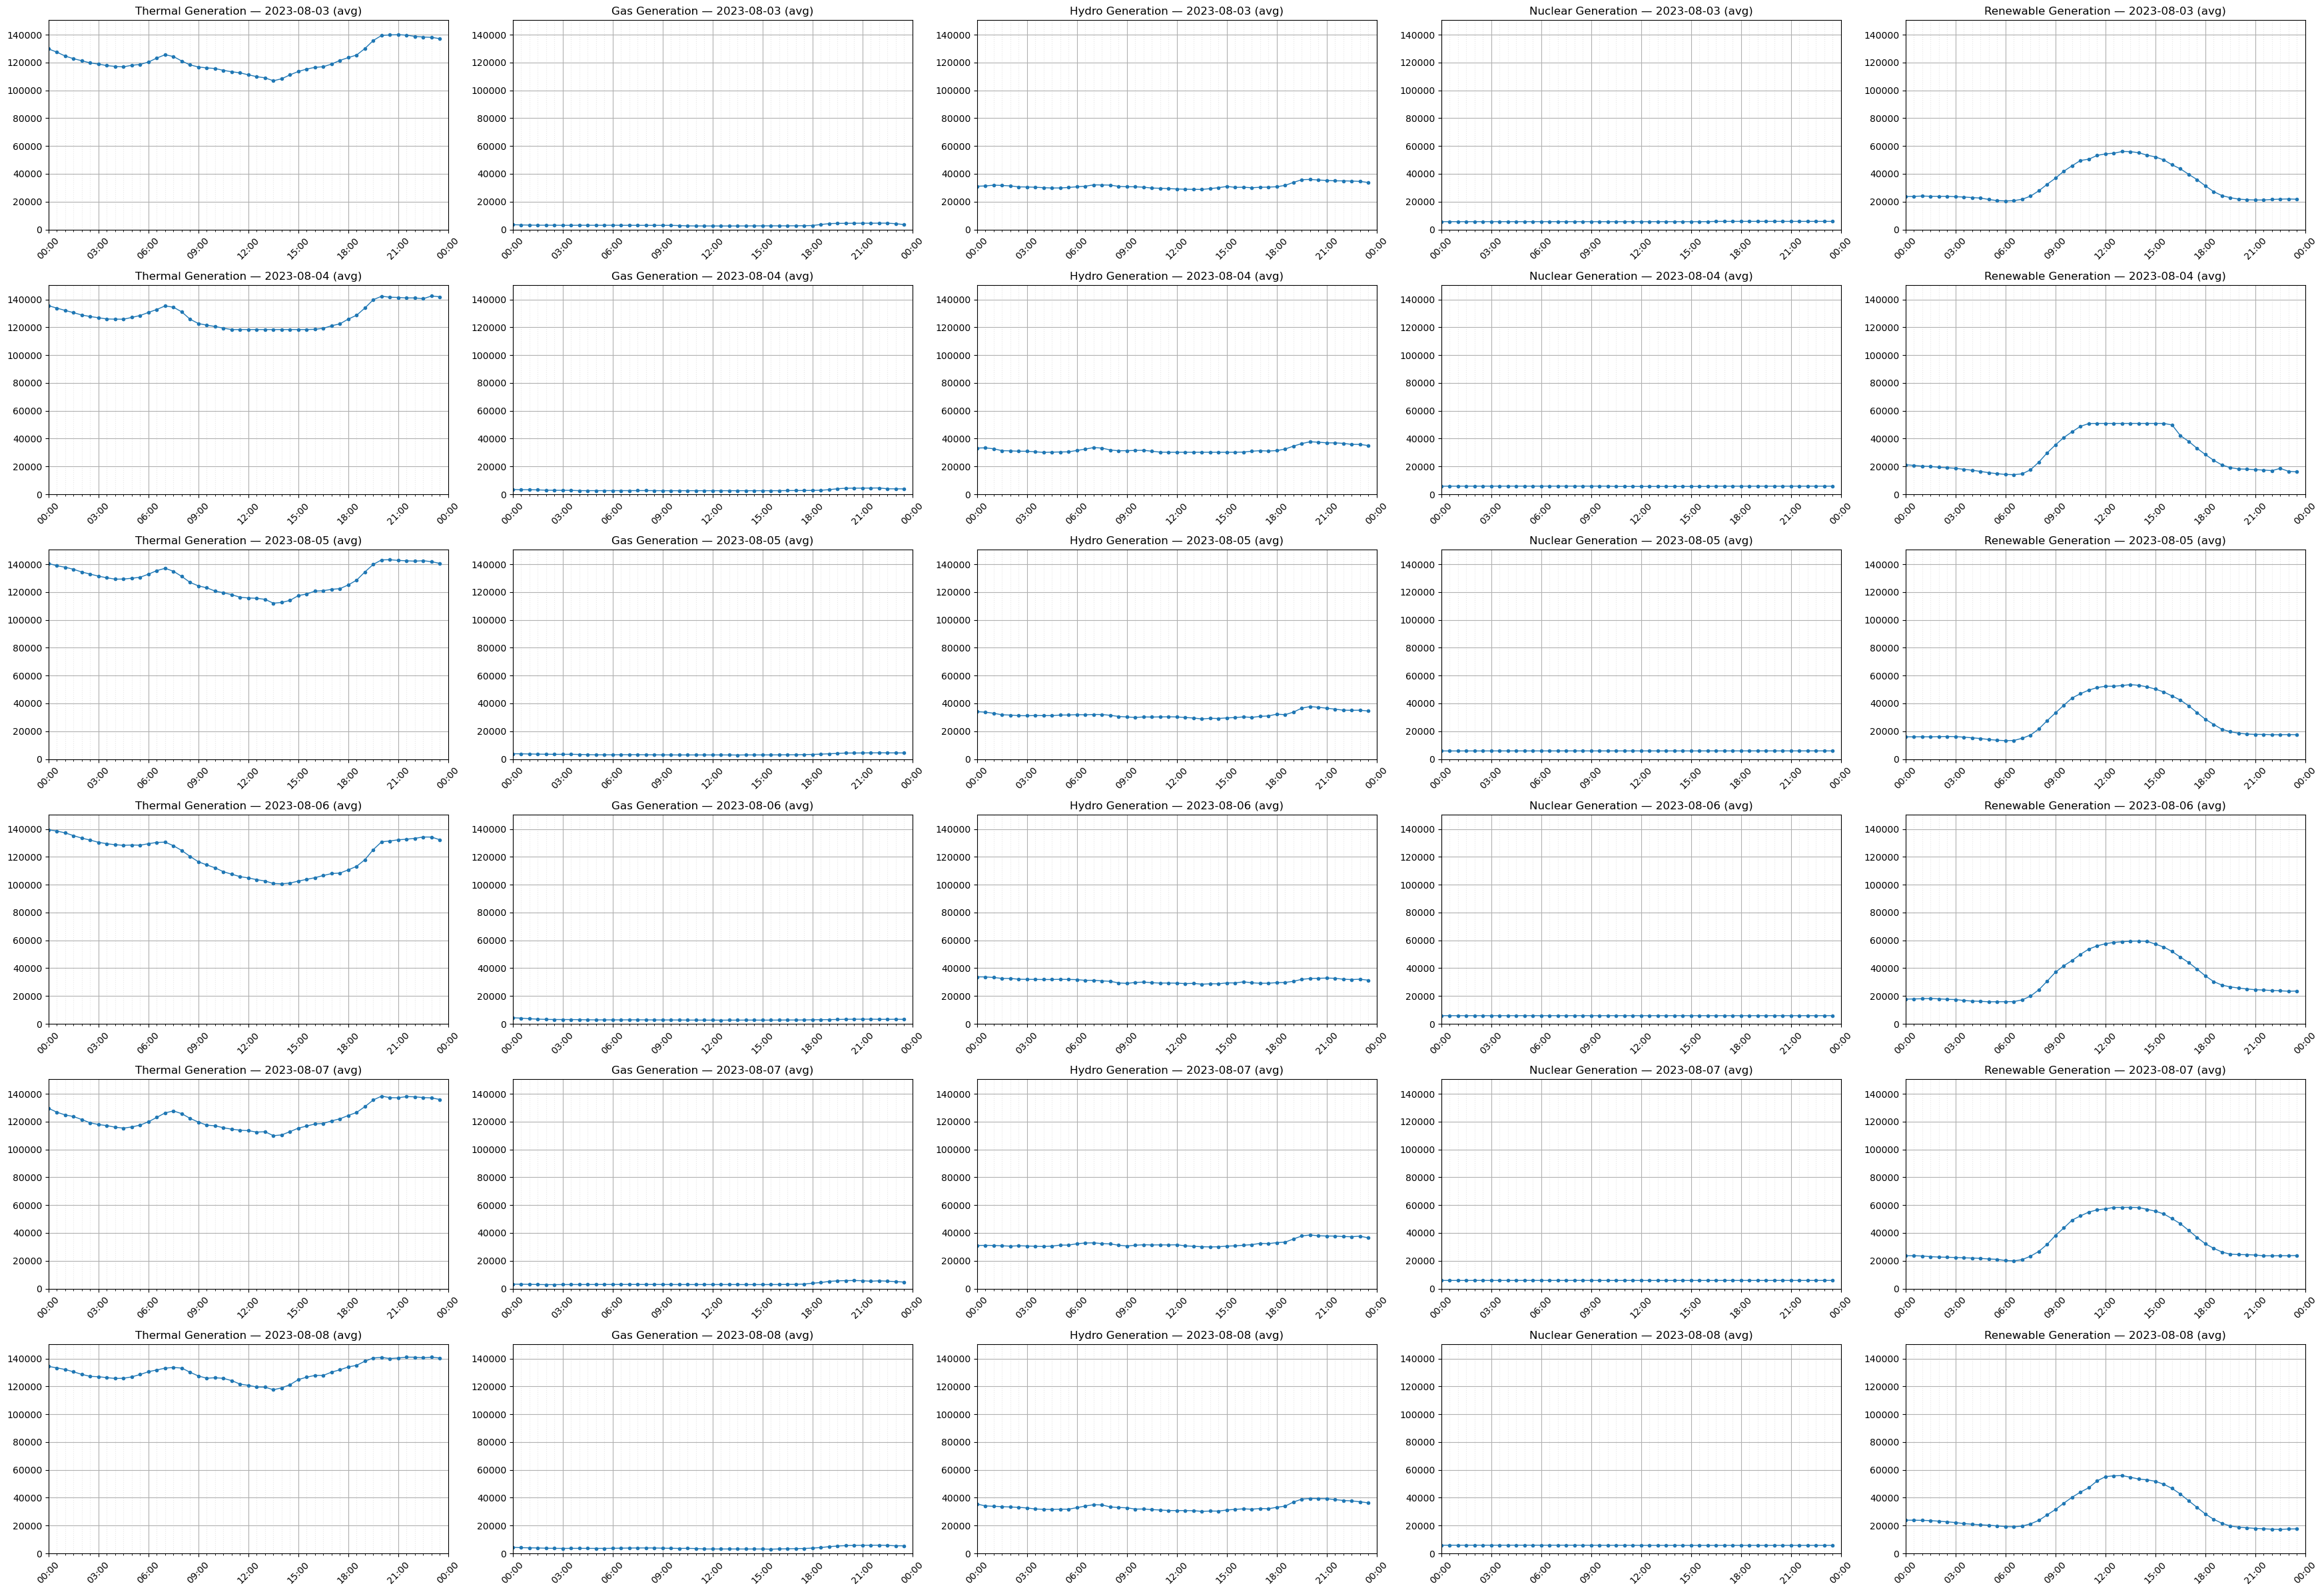

In [50]:
plot_daily_grid_of_variables(half_hour_grid_data_pldf,
                             variables=["thermal_generation", "gas_generation", "hydro_generation", "nuclear_generation", "renewable_generation"],
    start="2023-08-03T00:00:00",
    end="2023-08-08T00:00:00",
    freq_minutes=30,
    figsize_per_plot=(7, 4),
    unify_y_axis=True
)

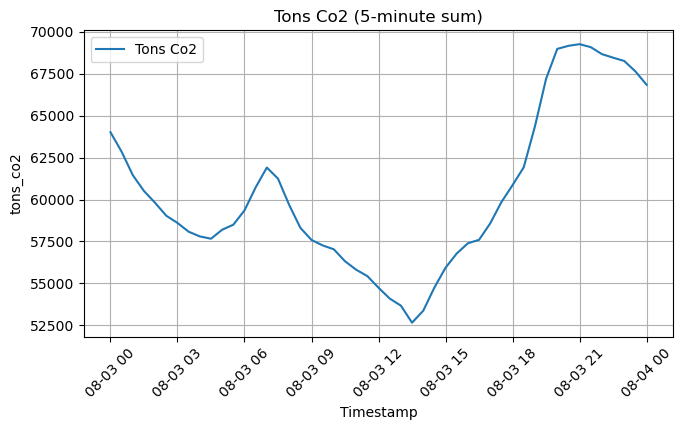

In [51]:
plot_variable_over_time(half_hour_grid_data_pldf,
                        variable="tons_co2",
                        start="2023-08-03T00:00:00",
                        end="2023-08-04T00:00:00",
                        start_y_at_zero=False,
                        figsize=(7, 4)
                       )

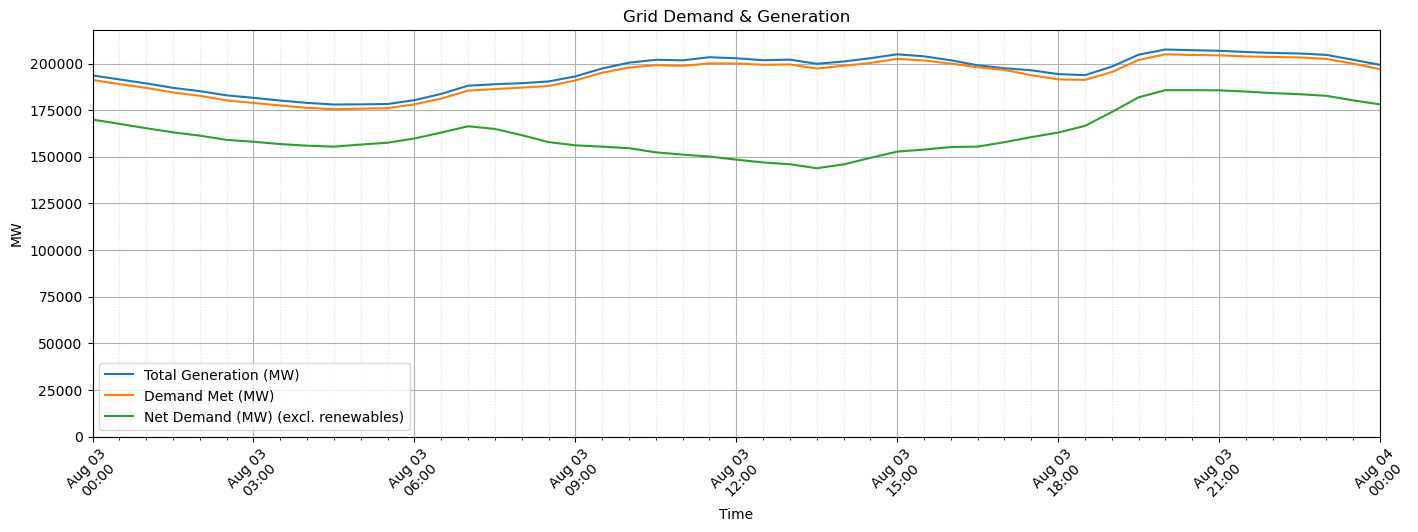

In [52]:
plot_time_series(
    df=half_hour_grid_data_pldf,
    value_cols=["total_generation", "demand_met", "non_renewable_generation"],
    timestamp_col="timestamp",
    start="2023-08-03T00:00:00",
    end="2023-08-04T00:00:00",
    freq_minutes=5,              # 5/30/60
    agg="mean",                  # or "sum"/"median"
    labels={
        "non_renewable_generation": "Net Demand (MW) (excl. renewables)",
        "total_generation": "Total Generation (MW)",
        "demand_met": "Demand Met (MW)",
    },
    ylabel="MW",
    title="Grid Demand & Generation",
    start_y_at_zero=True,
    major_hour_interval=3,
    minor_minute_interval=30,
)

##### Weather Data Visualization

In [53]:
half_hour_weather_data_pldf.sample(2)

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
datetime[μs],cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,list[struct[2]]
2024-01-06 12:00:00,"""mumbai""",18.8,72.87,18.799999,72.900002,5.777792,318.500885,27.300995,0.0,160334.225467,173901.38445,577203.211683,626044.984019,0.004456,0.0,0.004456,0.0,0.030002,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]"
2023-01-04 14:00:00,"""mumbai""",19.3,72.87,19.299999,72.900002,2.992086,325.748169,24.590485,2.0009e-7,0.00653,0.00739,23509.534553,26603.629895,0.0,0.0,0.0,0.0,0.030002,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""interval_surface_net_solar_radiation_kWh_per_m2"",""world_fill_interval""}, … {""interval_surface_solar_radiation_downwards_joules_per_m2"",""world_fill_interval""}]"


In [54]:
half_hour_weather_data_pldf_ts = half_hour_weather_data_pldf.with_columns(
    pl.col("timestamp").dt.convert_time_zone("UTC")
)

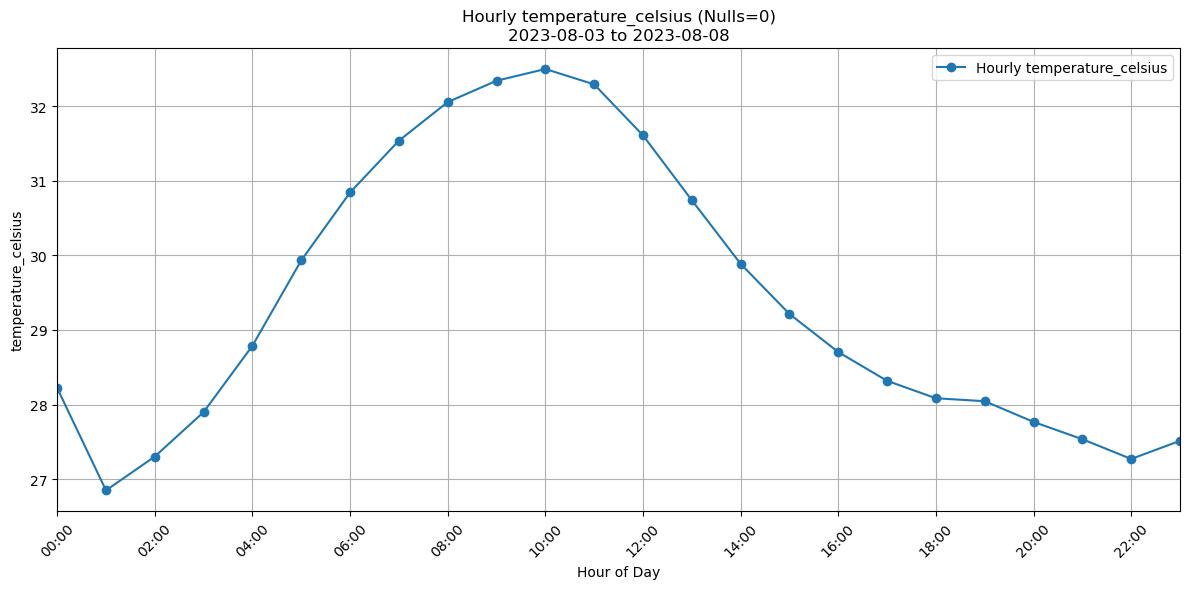

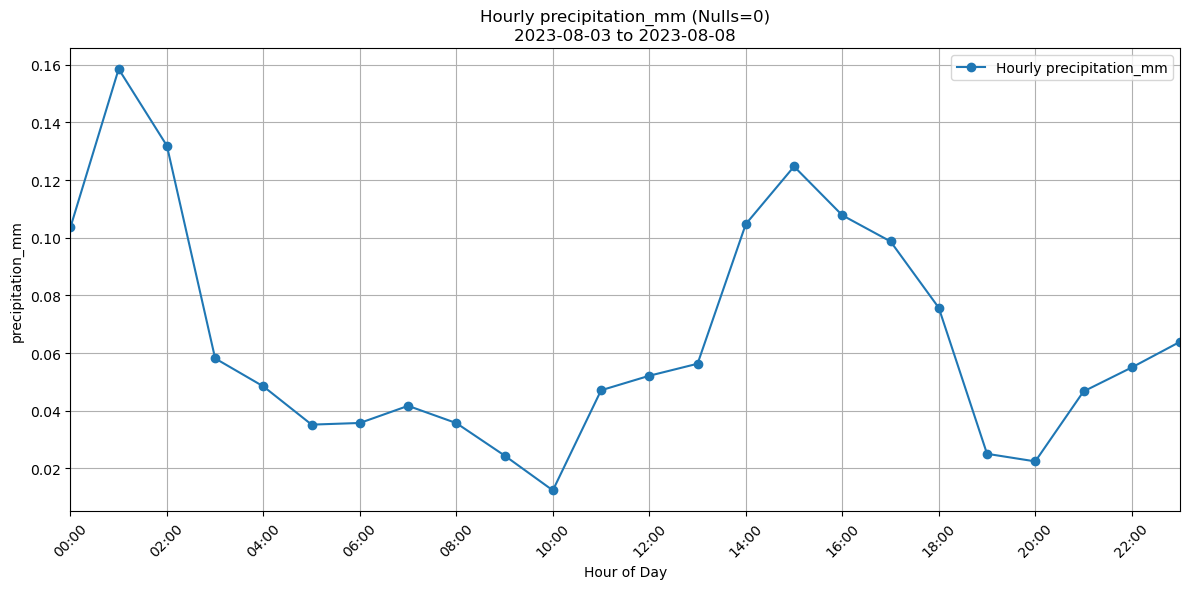

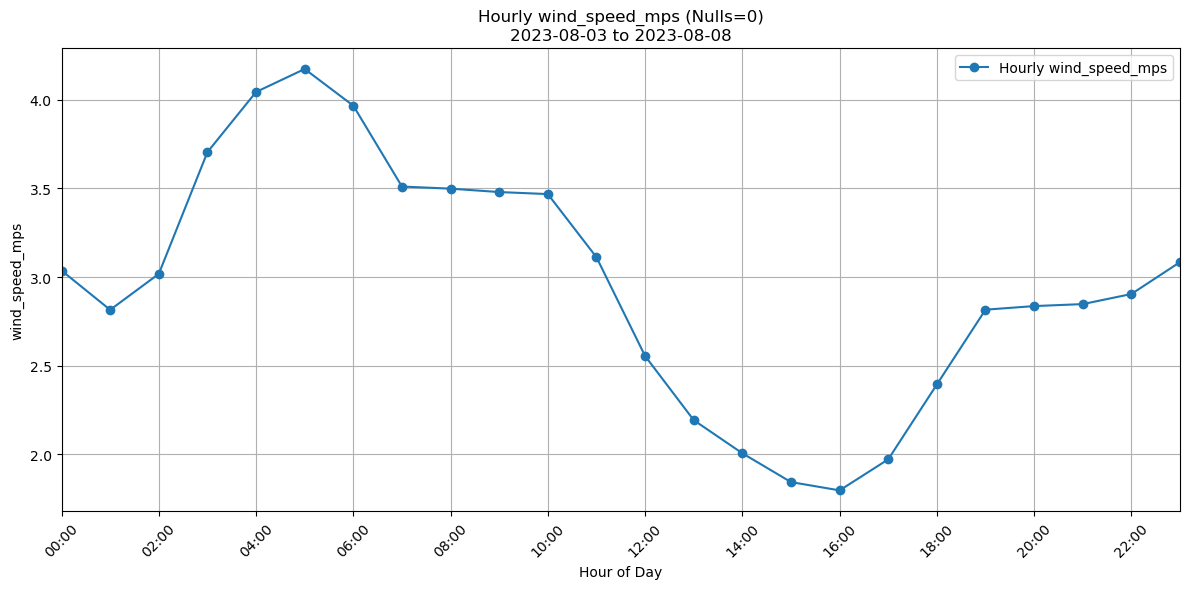

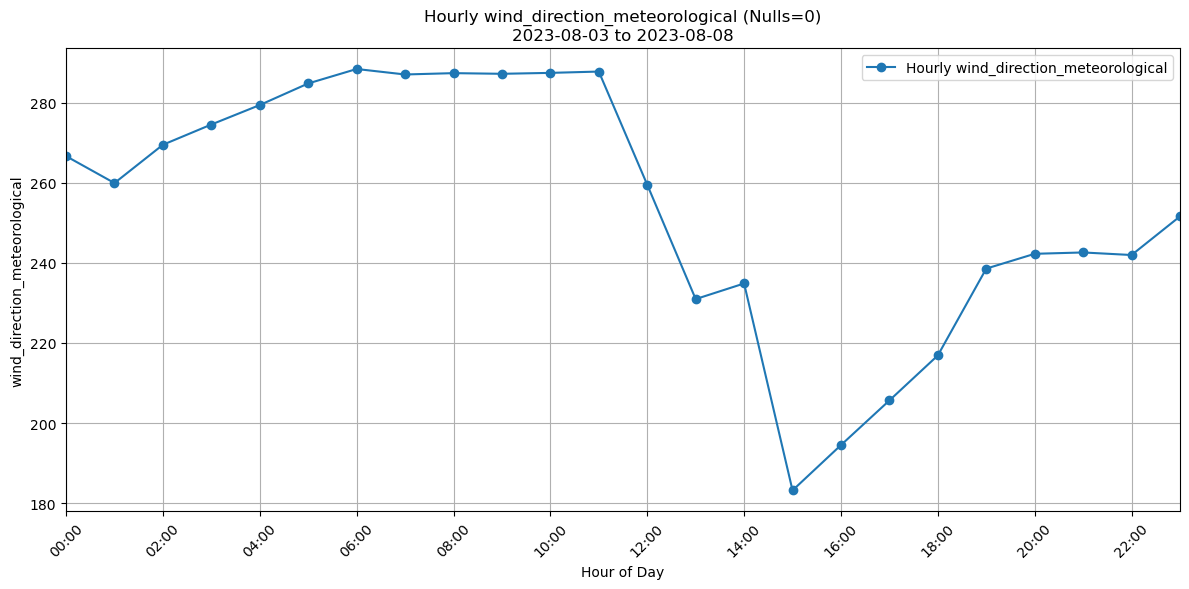

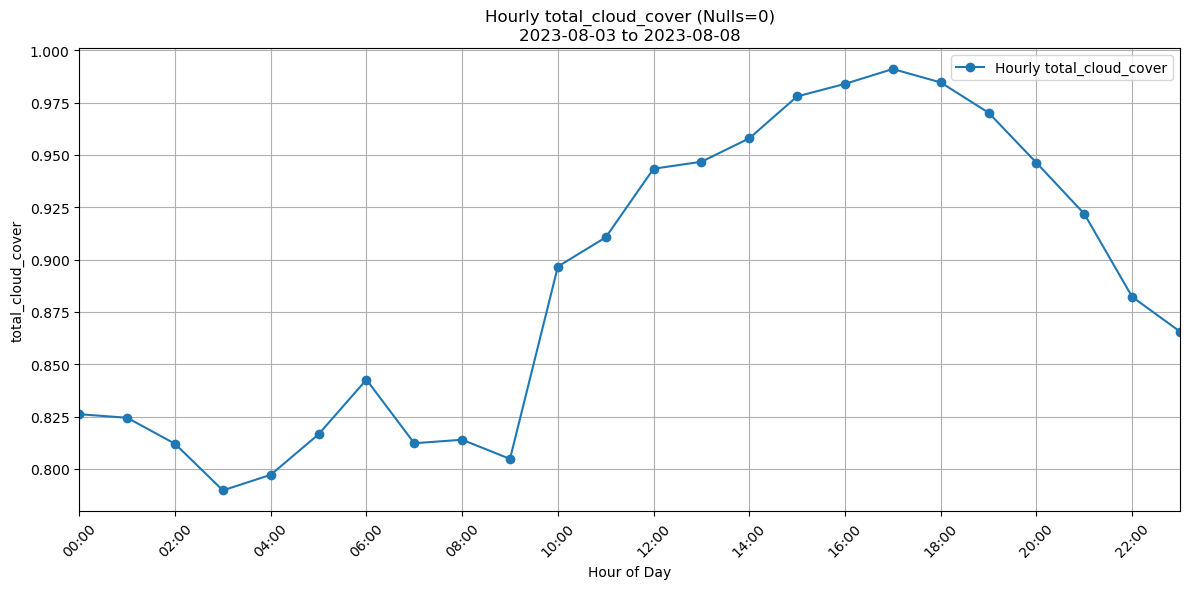

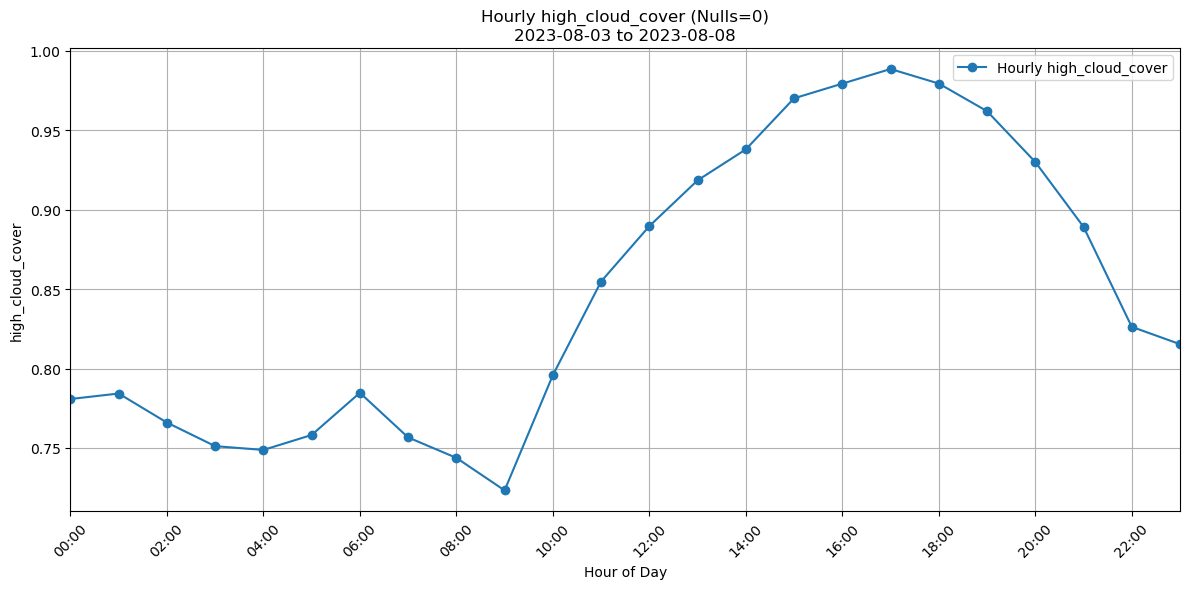

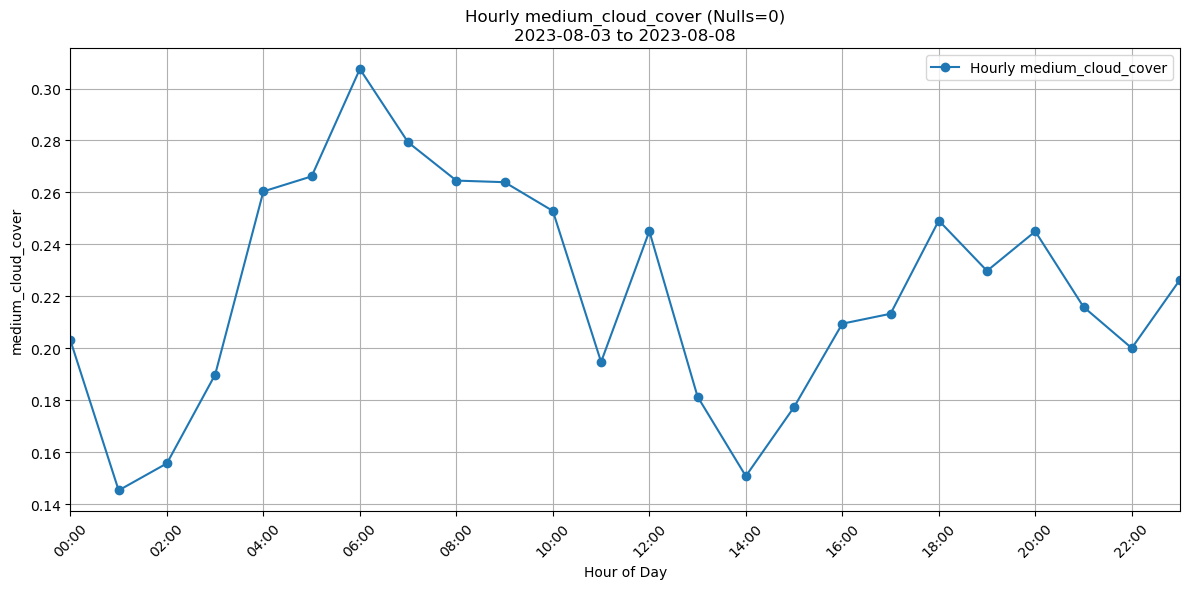

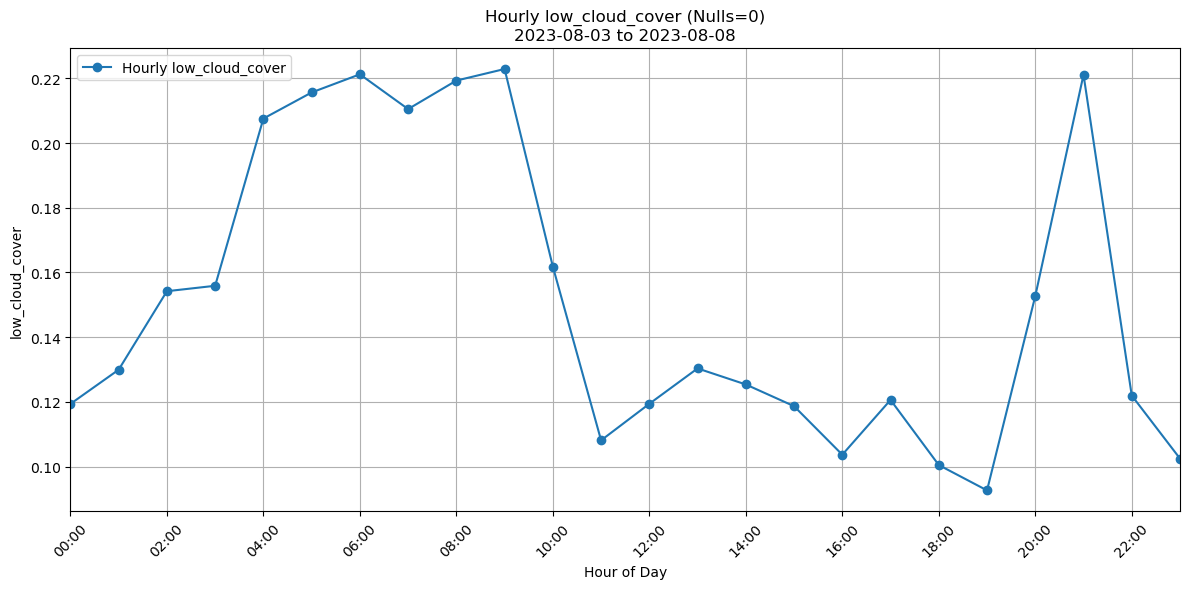

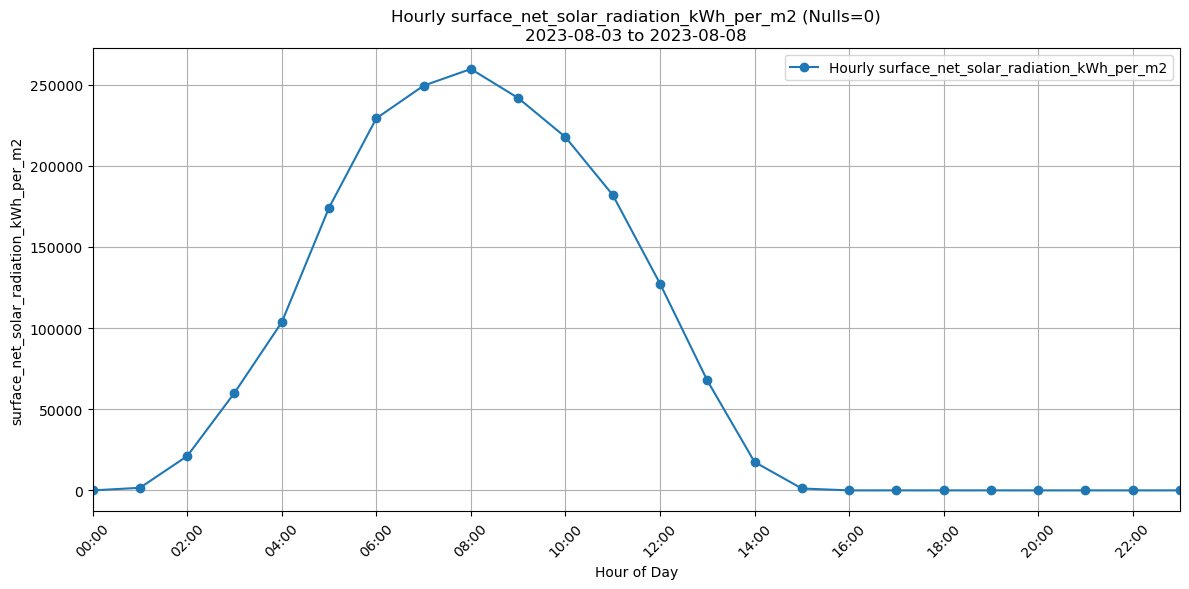

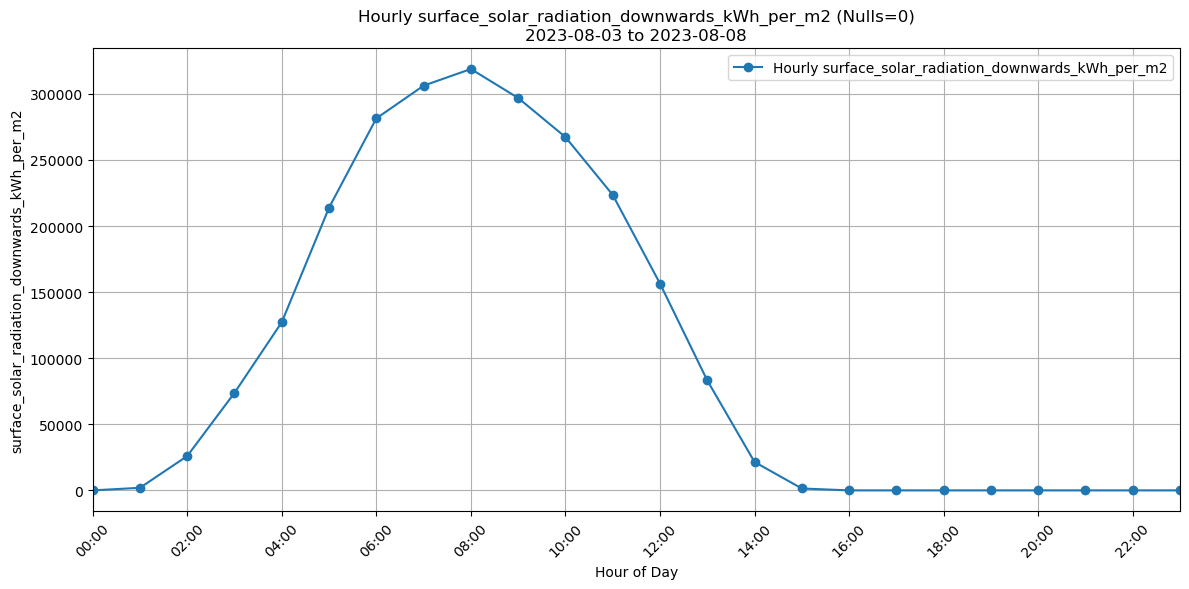

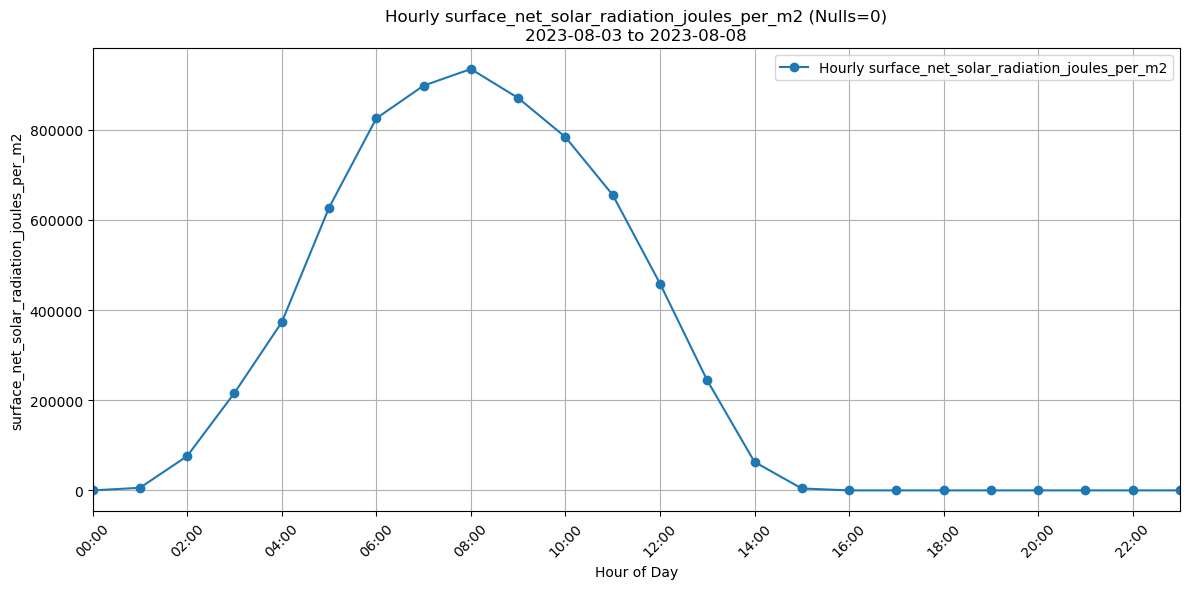

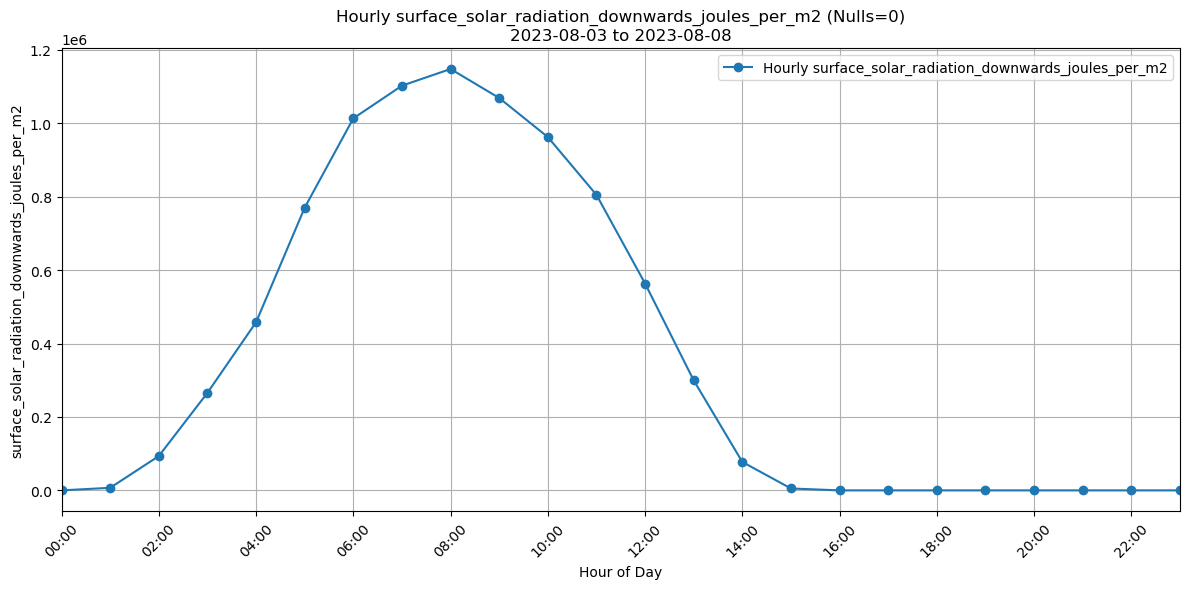

In [55]:
plot_hourly_averages(half_hour_weather_data_pldf_ts
                     ,
                    location_lat=28.6,
                    location_long=77.34,
                    start_date="2023-08-03",
                    end_date="2023-08-08",
                    longitude_col_name="land_longitude",
                    latitude_col_name="land_latitude",
                    variables=["temperature_celsius", "precipitation_mm",
                               "wind_speed_mps", "wind_direction_meteorological",
                               "total_cloud_cover", "high_cloud_cover",
                               "medium_cloud_cover", "low_cloud_cover",
                               "surface_net_solar_radiation_kWh_per_m2", "surface_solar_radiation_downwards_kWh_per_m2",
                               "surface_net_solar_radiation_joules_per_m2", "surface_solar_radiation_downwards_joules_per_m2",
                               ],
                     )

#### Aligning Temporal Boundaries

##### Setting / Converting Time Zones

In [56]:
half_hour_grid_data_pldf.sample(2)

timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-05-05 08:00:00,131202.875,3798.069444,12439.0,4453.888889,14457.166667,166351.0,166068.708333,151893.833333,64776.606325,778.793875,0.778794
2024-12-12 23:00:00,123018.666667,1720.666667,7745.25,6133.833333,19479.666667,158098.083333,153651.916667,138618.416667,60321.8444,763.076418,0.763076


In [57]:
# Setting time zone to IST
half_hour_grid_data_pldf = half_hour_grid_data_pldf.with_columns(
    pl.col("timestamp").dt.replace_time_zone("Asia/Kolkata")
)

In [58]:
half_hour_grid_data_pldf.sample(2)

timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
"datetime[μs, Asia/Kolkata]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-08-11 07:30:00 IST,144212.0,5508.75,33452.25,5858.666667,14152.75,203184.416667,201324.666667,189031.666667,71499.55515,703.801496,0.703801
2023-06-01 04:00:00 IST,145973.666667,2604.333333,16431.333333,4306.083333,8149.083333,177464.5,174443.916667,169315.416667,71704.3454,808.097719,0.808098


In [59]:
half_hour_weather_data_pldf.sample(2)

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
datetime[μs],cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,list[struct[2]]
2020-11-12 04:30:00,"""delhi""",28.7,76.84,28.700001,76.800003,0.243125,255.118607,23.692902,0.0,136823.258598,167573.35555,492563.730952,603264.079981,0.189026,0.167099,0.0,0.029892,0.039997,null
2023-03-27 02:30:00,"""delhi""",28.8,77.04,28.799999,77.0,2.34593,294.982574,17.775024,0.0,0.025369,0.031409,91329.086415,113071.124378,0.0,0.0,0.0,0.0,0.04,null


In [60]:
half_hour_weather_data_pldf = half_hour_weather_data_pldf.with_columns(
    pl.col("timestamp").dt.replace_time_zone("Asia/Kolkata")
)

In [61]:
half_hour_weather_data_pldf.sample(2)

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
"datetime[μs, Asia/Kolkata]",cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,list[struct[2]]
2022-09-27 22:30:00 IST,"""delhi""",28.5,77.14,28.5,77.099998,0.827821,293.483307,23.95668,0.0,0.0,0.0,0.0,0.0,0.114746,0.0,0.114746,0.0,0.040002,null
2025-05-22 15:30:00 IST,"""mumbai""",19.3,72.97,19.299999,73.0,1.742509,308.335297,28.792847,0.00087,0.0,0.0,0.0,0.0,0.997772,0.995575,0.828751,0.031708,0.03,null


In [62]:
print("-" * 80)
print("Descriptive Statistics for [half_hour_grid_data_pldf]\n" + "-" * 80)
display(half_hour_grid_data_pldf.describe())
print("\n" + "-" * 80)
print("Descriptive Statistics for [half_hour_weather_data_pldf]\n" + "-" * 80)
display(half_hour_weather_data_pldf.describe())


--------------------------------------------------------------------------------
Descriptive Statistics for [half_hour_grid_data_pldf]
--------------------------------------------------------------------------------


statistic,timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""95088""",95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0,95088.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-17 12:15:00+05:30""",127346.99741,3880.785326,17808.916682,5098.942404,18015.883059,172146.160136,170937.702059,154135.641823,62916.633837,734.108622,0.734109
"""std""",null,20916.196838,1619.355378,8617.821113,788.865947,14612.596141,26379.403551,26081.970354,22092.847367,10139.404973,76.549608,0.07655
"""min""","""2020-01-01 00:30:00+05:30""",66097.833333,109.483135,2516.0,2281.083333,0.0,95950.333333,96848.5,86763.333333,33384.3019,483.357945,0.483358
"""25%""","""2021-05-10 06:30:00+05:30""",111923.333333,2565.083333,10134.916667,4444.0,6740.833333,153551.166667,152501.5,138526.0,55405.58295,681.281762,0.681282
"""50%""","""2022-09-17 12:30:00+05:30""",128648.583333,3457.833333,16946.166667,5126.666667,12830.5,172655.166667,171276.583333,154052.0,63403.42905,734.684328,0.734684
"""75%""","""2024-01-25 18:00:00+05:30""",143295.5,4922.083333,24823.166667,5580.25,25190.333333,192577.333333,191039.902778,169530.333333,70569.09085,797.078569,0.797079
"""max""","""2025-06-04 00:00:00+05:30""",177508.083333,12915.75,43162.083333,7070.0,81927.666667,251763.666667,249591.916667,217778.833333,88742.75695,905.09159,0.905092



--------------------------------------------------------------------------------
Descriptive Statistics for [half_hour_weather_data_pldf]
--------------------------------------------------------------------------------


statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""4272525""","""4272525""",4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,4.272525e6,2.136285e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.13624e6
"""mean""","""2022-09-16 00:00:00+05:30""",null,25.393333,75.701111,25.393333,75.684448,2.628678,209.708649,25.250099,0.073619,83892.747074,100685.961949,326055.977172,390541.762503,0.358227,0.261578,0.15217,0.108001,0.036667,null
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,1.381585,108.889191,6.983283,0.331403,121288.164321,145163.046404,444710.546454,530957.466648,0.389875,0.379374,0.244133,0.222041,0.004713,null
"""min""","""2020-01-01 00:00:00+05:30""",null,18.5,72.77,18.5,72.800003,0.002416,0.0,0.487457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,null
"""25%""","""2021-05-09 12:00:00+05:30""",null,19.2,72.97,19.200001,73.0,1.68921,108.692078,21.503815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030002,null
"""50%""","""2022-09-16 00:00:00+05:30""",null,28.5,76.94,28.5,76.900002,2.407432,244.406693,26.366913,0.0,18.452495,22.273856,12591.478629,15056.932644,0.177643,0.000443,0.020996,0.0,0.039997,null
"""75%""","""2024-01-23 12:00:00+05:30""",null,28.7,77.14,28.700001,77.099998,3.305301,305.047485,29.59906,0.00268,161857.496908,194979.715337,648821.436581,779291.27267,0.763901,0.532104,0.21283,0.093506,0.04,null
"""max""","""2025-06-01 00:00:00+05:30""",null,28.8,77.34,28.799999,77.300003,19.006941,359.999786,46.374786,16.246036,4.6355e6,5.0640e6,1.6688e7,1.8230394e7,1.0,1.0,1.0,1.0,0.040003,null


##### Trimming Start and End of Datasets

In [63]:
# Checking Time Boundaries
print("\n" + "-" * 120)
print("Time Boundaries of Datasets:\n" + "-" * 120)
print("\t\tGrid Readings Dataset\t\tWeather Dataset")
print("-"*80)
print(f"Start Time:\t{half_hour_grid_data_pldf['timestamp'].min()}\t\t{half_hour_weather_data_pldf['timestamp'].min()}")
print(f"End Time:\t{half_hour_grid_data_pldf['timestamp'].max()}\t\t{half_hour_weather_data_pldf['timestamp'].max()}")
print(f"Total Duration:\t{half_hour_grid_data_pldf['timestamp'].max() - half_hour_grid_data_pldf['timestamp'].min()}\t\t\t{half_hour_weather_data_pldf['timestamp'].max() - half_hour_weather_data_pldf['timestamp'].min()}")


------------------------------------------------------------------------------------------------------------------------
Time Boundaries of Datasets:
------------------------------------------------------------------------------------------------------------------------
		Grid Readings Dataset		Weather Dataset
--------------------------------------------------------------------------------
Start Time:	2020-01-01 00:30:00+05:30		2020-01-01 00:00:00+05:30
End Time:	2025-06-04 00:00:00+05:30		2025-06-01 00:00:00+05:30
Total Duration:	1980 days, 23:30:00			1978 days, 0:00:00


In [64]:
# Trimming Beginning of datasets
trimmed_half_hour_grid_data_pldf = half_hour_grid_data_pldf.filter(
    (pl.col("timestamp") >= pl.datetime(2021, 1, 1, time_zone="Asia/Kolkata"))
)

trimmed_half_hour_weather_data_pldf = half_hour_weather_data_pldf.filter(
    (pl.col("timestamp") >= pl.datetime(2021, 1, 1, time_zone="Asia/Kolkata"))
)

In [65]:
# Checking Time Boundaries
print("\n" + "-" * 120)
print("Time Boundaries of Datasets:\n" + "-" * 120)
print("\t\tGrid Readings Dataset\t\tWeather Dataset")
print("-"*80)
print(f"Start Time:\t{trimmed_half_hour_grid_data_pldf['timestamp'].min()}\t\t{trimmed_half_hour_weather_data_pldf['timestamp'].min()}")
print(f"End Time:\t{trimmed_half_hour_grid_data_pldf['timestamp'].max()}\t\t{trimmed_half_hour_weather_data_pldf['timestamp'].max()}")
print(f"Total Duration:\t{trimmed_half_hour_grid_data_pldf['timestamp'].max() - trimmed_half_hour_grid_data_pldf['timestamp'].min()}\t\t\t{trimmed_half_hour_weather_data_pldf['timestamp'].max() - trimmed_half_hour_weather_data_pldf['timestamp'].min()}")


------------------------------------------------------------------------------------------------------------------------
Time Boundaries of Datasets:
------------------------------------------------------------------------------------------------------------------------
		Grid Readings Dataset		Weather Dataset
--------------------------------------------------------------------------------
Start Time:	2021-01-01 00:00:00+05:30		2021-01-01 00:00:00+05:30
End Time:	2025-06-04 00:00:00+05:30		2025-06-01 00:00:00+05:30
Total Duration:	1615 days, 0:00:00			1612 days, 0:00:00


In [66]:
# Trimming end of datasets
trimmed_half_hour_grid_data_pldf = trimmed_half_hour_grid_data_pldf.filter(
    (pl.col("timestamp") < pl.datetime(2025, 6, 1, time_zone="Asia/Kolkata"))
)

trimmed_half_hour_weather_data_pldf = trimmed_half_hour_weather_data_pldf.filter(
    (pl.col("timestamp") < pl.datetime(2025, 6, 1, time_zone="Asia/Kolkata"))
)


In [67]:
# Checking Time Boundaries
print("\n" + "-" * 120)
print("Time Boundaries of Datasets:\n" + "-" * 120)
print("\t\tGrid Readings Dataset\t\tWeather Dataset")
print("-"*80)
print(f"Start Time:\t{trimmed_half_hour_grid_data_pldf['timestamp'].min()}\t\t{trimmed_half_hour_weather_data_pldf['timestamp'].min()}")
print(f"End Time:\t{trimmed_half_hour_grid_data_pldf['timestamp'].max()}\t\t{trimmed_half_hour_weather_data_pldf['timestamp'].max()}")
print(f"Total Duration:\t{trimmed_half_hour_grid_data_pldf['timestamp'].max() - trimmed_half_hour_grid_data_pldf['timestamp'].min()}\t\t\t{trimmed_half_hour_weather_data_pldf['timestamp'].max() - trimmed_half_hour_weather_data_pldf['timestamp'].min()}")


------------------------------------------------------------------------------------------------------------------------
Time Boundaries of Datasets:
------------------------------------------------------------------------------------------------------------------------
		Grid Readings Dataset		Weather Dataset
--------------------------------------------------------------------------------
Start Time:	2021-01-01 00:00:00+05:30		2021-01-01 00:00:00+05:30
End Time:	2025-05-31 23:30:00+05:30		2025-05-31 23:30:00+05:30
Total Duration:	1611 days, 23:30:00			1611 days, 23:30:00


#### Joining 

In [68]:
half_hour_output_filepath_step2

'../../data/hitachi/weather_data_combined_20250714_1401_half_hourly_step2.parquet'

In [69]:
trimmed_half_hour_weather_data_filepath = half_hour_output_filepath_step2.replace(".parquet", "_trimmed.parquet")
trimmed_half_hour_grid_data_filepath = grid_readings_filepath.replace(".parquet", "_trimmed.parquet")

In [70]:
try:
    trimmed_half_hour_weather_data_pldf.write_parquet(trimmed_half_hour_weather_data_filepath,
                                            compression="snappy",
                                            statistics=True,)
    print(f"Trimmed half-hour weather data written to {trimmed_half_hour_weather_data_filepath}")
    temp_files.append(trimmed_half_hour_weather_data_filepath)

except Exception as e:
    print(f"Error writing trimmed half-hour weather data: {e}")

Trimmed half-hour weather data written to ../../data/hitachi/weather_data_combined_20250714_1401_half_hourly_step2_trimmed.parquet


In [71]:
try:
    trimmed_half_hour_grid_data_pldf.write_parquet(trimmed_half_hour_grid_data_filepath,
                                          compression="snappy",
                                          statistics=True,)
    print(f"Trimmed half-hour grid data written to {trimmed_half_hour_grid_data_filepath}")
    temp_files.append(trimmed_half_hour_grid_data_filepath)

except Exception as e:
    print(f"Error writing trimmed half-hour grid data: {e}")

Trimmed half-hour grid data written to ../../data/hitachi/grid_readings_20250714_1401_processed_trimmed.parquet


In [72]:
trimmed_half_hour_weather_data_filename = os.path.basename(trimmed_half_hour_weather_data_filepath)
pattern = r"(\d{8})_(\d{4})"  # 8 digits, underscore, 4 digits
match = re.search(pattern, trimmed_half_hour_weather_data_filename)

output_filepath = os.path.join(hitachi_data_directory,f"weather_and_grid_data_half-hourly_{match.group(1)}_{match.group(2)}.parquet")

In [73]:
with pl.StringCache():
    weather_lf = (pl.read_parquet(trimmed_half_hour_weather_data_filepath).lazy())
    grid_lf = (pl.read_parquet(trimmed_half_hour_grid_data_filepath).lazy())

    stacked_lf = weather_lf.join(grid_lf, on="timestamp", how="inner")

    # Efficiently write to parquet without collecting
    stacked_lf.sink_parquet(output_filepath)

# check if successful
if os.path.exists(output_filepath):
    print(f"Stacked DataFrame saved successfully to [{output_filepath}]")
else:
    print(f"Failed to save Stacked DataFrame to [{output_filepath}]")

Stacked DataFrame saved successfully to [../../data/hitachi/weather_and_grid_data_half-hourly_20250714_1401.parquet]


In [74]:
output_df = pl.read_parquet(output_filepath)

In [75]:
output_df.head(8)

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
"datetime[μs, Asia/Kolkata]",cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,list[struct[2]],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-04-24 01:00:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,1.613167,315.125244,23.278412,0.0,7.5000e-19,0.0,2.7000e-12,0.0,0.155609,0.0,0.155609,0.0,0.030002,[],166794.166667,6499.25,14535.666667,6420.916667,7880.083333,202130.083333,201699.25,194250.0,82724.44925,818.528936,0.818529
2024-04-24 06:30:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,2.625806,308.699829,34.524841,0.0,384165.23901,437423.528927,1.3830e6,1.5747e6,0.031662,0.0,0.031662,0.0,0.030002,null,163602.833333,4764.75,11567.083333,6425.25,6394.166667,192754.083333,191191.0,186359.916667,80779.36915,838.166466,0.838166
2024-04-24 08:30:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,4.001717,290.160614,35.567657,0.0,429686.880257,489249.602169,1.5469e6,1.7613e6,0.0,0.0,0.0,0.0,0.030002,null,148544.666667,4766.416667,9089.583333,6415.333333,26141.75,194957.75,194198.083333,168816.0,73443.40535,753.455507,0.753456
2024-04-24 10:30:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,4.872789,292.071259,34.321899,0.0,346308.76283,394299.493439,1.2467e6,1.4195e6,0.392044,0.0,0.392044,0.0,0.030002,null,143647.25,4821.666667,7141.25,6379.25,47665.666667,209655.083333,208976.25,161989.416667,71069.8152,677.978075,0.677978
2024-04-24 22:30:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,0.783221,279.917419,26.597122,0.0,0.0,0.0,0.0,0.0,0.402847,0.08577,0.39505,0.00499,0.030002,null,173121.25,7633.5,20093.833333,5890.25,9218.583333,215957.416667,215313.75,206738.833333,86062.2105,797.035976,0.797036
2024-04-25 03:30:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,2.354253,340.659424,30.347778,0.0,107586.204115,122522.672427,387310.334815,441081.620735,0.31752,0.016663,0.314758,0.000015,0.030002,null,167937.75,5192.833333,10885.0,5926.5,8183.166667,198125.25,196950.833333,189942.083333,82987.6593,837.730862,0.837731
2024-04-25 22:00:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,2.347546,305.630341,26.35257,0.0,0.0,0.0,0.0,0.0,0.558716,0.033478,0.553192,0.0,0.030002,"[{""deacc_precipitation_mm"",""deaccumulate_land""}, {""deacc_surface_net_solar_radiation_kWh_per_m2"",""deaccumulate_land""}, … {""deacc_surface_solar_radiation_downwards_joules_per_m2"",""deaccumulate_land""}]",173090.416667,8056.416667,19684.25,5923.25,9210.916667,215965.25,215522.75,206754.333333,86142.34475,797.750071,0.79775
2024-04-26 01:00:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,1.072353,10.101593,25.854523,0.0,7.5000e-19,0.0,2.7000e-12,0.0,0.446747,0.187805,0.357849,0.0,0.030002,[],172486.083333,8589.5,16524.333333,5934.083333,8923.666667,212457.666667,213761.916667,203534.0,85967.8573,809.277884,0.809278


In [76]:
output_df = output_df.sort("timestamp", descending=False, nulls_last=True)
output_df.head(5)

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
"datetime[μs, Asia/Kolkata]",cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,list[struct[2]],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-01-01 00:00:00 IST,"""mumbai""",19.3,72.97,19.299999,73.0,1.358395,48.168091,20.579742,0.0,0.0,0.0,0.0,0.0,0.119873,0.0,0.119873,0.005554,0.03,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033
2021-01-01 00:00:00 IST,"""mumbai""",18.8,72.87,18.799999,72.900002,2.018885,39.003723,22.959045,0.0,0.0,0.0,0.0,0.0,0.040039,0.0,0.040039,0.0,0.030002,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033
2021-01-01 00:00:00 IST,"""mumbai""",18.9,72.97,18.9,73.0,1.629554,51.939392,21.894989,0.0,0.0,0.0,0.0,0.0,0.062012,0.0,0.062012,0.01004,0.03,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033
2021-01-01 00:00:00 IST,"""mumbai""",19.0,72.87,19.0,72.900002,2.093624,36.494019,22.910614,0.0,0.0,0.0,0.0,0.0,0.062012,0.0,0.062012,0.01004,0.030002,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033
2021-01-01 00:00:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,1.596676,37.234253,21.177429,0.0,0.0,0.0,0.0,0.0,0.119873,0.0,0.119873,0.005554,0.030002,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033


In [77]:
output_df.describe()

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""3481920""","""3481920""",3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,1.74096e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6,3.48192e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.74096e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2023-03-17 23:45:00+05:30""",null,25.393333,75.701111,25.393333,75.684448,2.63187,209.982468,25.316455,0.071264,82469.322585,98989.168512,326390.622348,390807.372846,0.359816,0.264307,0.152118,0.107959,0.036667,null,133038.493588,3488.657373,17616.983083,5208.884506,19337.656218,178684.081988,177287.744297,159353.018551,65601.301985,738.359913,0.73836
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,1.382159,109.031609,6.983781,0.309506,120344.556357,144109.410049,443361.492633,529310.34544,0.392301,0.381599,0.245868,0.22307,0.004713,null,17973.982837,1459.834657,8805.004409,789.721015,15436.03158,23615.234305,23535.203493,19941.80274,8839.633217,78.292944,0.078293
"""min""","""2021-01-01 00:00:00+05:30""",null,18.5,72.77,18.5,72.800003,0.002416,0.000122,2.149261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,null,75325.666667,109.483135,2516.0,2281.083333,0.0,106969.666667,105140.916667,95292.666667,37529.27105,483.357945,0.483358
"""25%""","""2022-02-08 00:00:00+05:30""",null,19.2,72.97,19.200001,73.0,1.691567,108.210403,21.588165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030002,null,120050.666667,2438.416667,9761.166667,4668.166667,7047.833333,162359.083333,160999.75,145527.666667,59239.9249,685.649915,0.68565
"""50%""","""2023-03-18 00:00:00+05:30""",null,28.5,76.94,28.5,76.900002,2.411643,246.204437,26.381775,0.0,0.307726,0.360172,12536.50589,15013.505001,0.175415,0.0,0.01825,0.0,0.039997,null,134184.5,3060.5,16623.25,5214.083333,13690.583333,179752.833333,178227.333325,159159.833333,66137.34125,740.288715,0.740289
"""75%""","""2024-04-23 23:30:00+05:30""",null,28.7,77.14,28.700001,77.099998,3.309765,304.86676,29.635712,0.002179,157134.975143,189414.069345,649476.992699,779902.687006,0.776154,0.551407,0.21228,0.09198,0.04,null,145811.583333,4216.25,24520.083333,5757.75,28750.416667,196273.0,194806.833333,173136.916667,71813.8573,802.991573,0.802992
"""max""","""2025-05-31 23:30:00+05:30""",null,28.8,77.34,28.799999,77.300003,19.006941,359.999786,46.374786,16.104477,465916.895282,530511.99554,1.6773e6,1.9098e6,1.0,1.0,1.0,1.0,0.040003,null,177508.083333,12915.75,43162.083333,7070.0,75828.666667,251763.666667,249591.916667,217778.833333,88742.75695,905.09159,0.905092


In [78]:
# save after ensuring it is sorted
output_df.write_parquet(output_filepath)

#### Adding Wind Directions

In [79]:
output_df = output_df.with_columns(
    (degrees_to_cardinal(pl.col("wind_direction_meteorological"), num_directions=8)
      .alias("wind_dir_cardinal_8")),
    (degrees_to_cardinal(pl.col("wind_direction_meteorological"), num_directions=16)
      .alias("wind_dir_cardinal_16")),
    (degrees_to_cardinal(pl.col("wind_direction_meteorological"), num_directions=4)
      .alias("wind_dir_cardinal_4"))
)

In [80]:
output_df

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,demand_met,non_renewable_generation,tons_co2,g_co2_per_kwh,tons_co2_per_mwh,wind_dir_cardinal_8,wind_dir_cardinal_16,wind_dir_cardinal_4
"datetime[μs, Asia/Kolkata]",cat,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,list[struct[2]],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str
2021-01-01 00:00:00 IST,"""mumbai""",19.3,72.97,19.299999,73.0,1.358395,48.168091,20.579742,0.0,0.0,0.0,0.0,0.0,0.119873,0.0,0.119873,0.005554,0.03,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033,"""NE""","""NE""","""E"""
2021-01-01 00:00:00 IST,"""mumbai""",18.8,72.87,18.799999,72.900002,2.018885,39.003723,22.959045,0.0,0.0,0.0,0.0,0.0,0.040039,0.0,0.040039,0.0,0.030002,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033,"""NE""","""NE""","""N"""
2021-01-01 00:00:00 IST,"""mumbai""",18.9,72.97,18.9,73.0,1.629554,51.939392,21.894989,0.0,0.0,0.0,0.0,0.0,0.062012,0.0,0.062012,0.01004,0.03,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033,"""NE""","""NE""","""E"""
2021-01-01 00:00:00 IST,"""mumbai""",19.0,72.87,19.0,72.900002,2.093624,36.494019,22.910614,0.0,0.0,0.0,0.0,0.0,0.062012,0.0,0.062012,0.01004,0.030002,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033,"""NE""","""NE""","""N"""
2021-01-01 00:00:00 IST,"""mumbai""",19.3,72.87,19.299999,72.900002,1.596676,37.234253,21.177429,0.0,0.0,0.0,0.0,0.0,0.119873,0.0,0.119873,0.005554,0.030002,"[{""precipitation_mm"",""world_override_hour""}, {""temperature"",""world_override_hour""}, … {""surface_solar_radiation_downwards_joules_per_m2"",""world_override_hour""}]",104749.916667,3792.166667,7374.833333,4015.083333,9457.416667,129389.416667,129481.666667,119932.0,51887.3969,802.033059,0.802033,"""NE""","""NE""","""N"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-05-31 23:30:00 IST,"""delhi""",28.8,77.04,28.799999,77.0,3.293586,196.896637,29.675735,0.0,0.0,0.0,0.0,0.0,0.226883,0.0,0.226883,0.0,0.04,null,151636.416667,2371.75,29448.333333,6053.25,25273.5,214783.25,212822.75,189509.75,74410.90595,692.893751,0.692894,"""S""","""SSW""","""S"""
2025-05-31 23:30:00 IST,"""delhi""",28.7,77.24,28.700001,77.199997,2.835068,202.26796,29.615128,0.0,0.0,0.0,0.0,0.0,0.243881,0.009003,0.243881,0.0,0.040003,null,151636.416667,2371.75,29448.333333,6053.25,25273.5,214783.25,212822.75,189509.75,74410.90595,692.893751,0.692894,"""S""","""SSW""","""S"""
2025-05-31 23:30:00 IST,"""delhi""",28.8,77.14,28.799999,77.0

In [81]:
try:
    output_df.write_parquet(output_filepath)
    print(f"Output DataFrame written to {output_filepath}")

except Exception as e:
    print(f"Error writing output DataFrame: {e}")

Output DataFrame written to ../../data/hitachi/weather_and_grid_data_half-hourly_20250714_1401.parquet


### Cleanup

In [82]:
# Remove the temporary files created during processing
for filepath in temp_files:
    try:
        os.remove(filepath)
        print(f"Temporary file {filepath} removed successfully.")
    except Exception as e:
        print(f"Error removing temporary file {filepath}: {e}")
print("\n" + "-" * 120)
print("Processing complete. All temporary files removed.")

Temporary file ../../data/hitachi/weather_data_combined_20250714_1401_half_hourly.parquet removed successfully.
Temporary file ../../data/hitachi/weather_data_combined_20250714_1401_half_hourly_step2.parquet removed successfully.
Temporary file ../../data/hitachi/weather_data_combined_20250714_1401_half_hourly_step2_trimmed.parquet removed successfully.
Temporary file ../../data/hitachi/grid_readings_20250714_1401_processed_trimmed.parquet removed successfully.

------------------------------------------------------------------------------------------------------------------------
Processing complete. All temporary files removed.


### Summary

**Overview**

This notebook creates a comprehensive half-hourly dataset by combining high-resolution weather data with electrical grid readings across Delhi and Mumbai. The resulting dataset enables analysis of weather impacts on electricity demand, generation patterns, and carbon emissions from 2021 to 2025.


**Data Processing**
1. **Time Alignment**: 
   - Standardized all timestamps to Asia/Kolkata timezone
   - Trimmed datasets to consistent 2021-01-01 to 2025-06-01 timeframe
   - Adjusted grid reading timestamps to follow end-of-interval convention

2. **Temporal Resampling**:
   - Converted 5-minute grid readings to half-hourly intervals using appropriate aggregation:
     - Generation values (MW): Averaged to preserve power measurement integrity
     - Carbon emissions (tons CO2): Summed to maintain total emissions
   - Downsampled hourly weather data to half-hourly using variable-appropriate methods:
     - Intensive measurements (temperature, wind speed): Linear interpolation
     - Solar radiation: Rate-shaped splitting with diurnal pattern preservation
     - Precipitation: Even distribution across half-hour periods
     - Wind direction: Vector-based circular interpolation with speed weighting

3. **Additional Processing**:
   - Added cardinal wind direction representations (4, 8, and 16-point scales) for simplified analysis
   - Performed data type optimization for storage efficiency (e.g., Float32 for distance measurements)
   - Applied range constraints to ensure physical validity (e.g., cloud cover clamped to 0-1 range)
   - Implemented proper handling of cumulative variables requiring deaccumulation


**Dataset Features**

* Weather Variables
    - *Temperature*: Celsius, instantaneous half-hourly readings
    - *Wind*: Speed (m/s) and direction (degrees, plus cardinal indicators at 4/8/16 point resolution)
    - *Precipitation*: mm per half-hour, evenly distributed from hourly totals
    - *Solar Radiation*: kWh/m² and joules/m², with diurnal pattern preservation
    - *Cloud Cover*: Total, high, medium, and low cloud fraction (0-1)

* Grid Variables
    - *Generation by Source*: Thermal, gas, hydro, nuclear, and renewable generation (MW)
    - *System Demand*: Demand met and non-renewable generation (MW)
    - *Carbon Intensity*: Emissions factor (g CO₂/kWh and tons CO₂/MWh)
    - *Carbon Emissions*: Half-hourly CO₂ emissions (tons)